## Problem Statement: 
1.	Predict the department-wise weekly_sales 
2.	Model the effects of markdowns on holiday weeks
3.	Provide recommended actions based on the insights drawn, with prioritization placed on largest business impact

### Target Variable : Weekly Sales

## Data Description :

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store  (TARGET VARIABLE)
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not        available for all stores all the time. Any missing value is marked with an NA
- CPI - the consumer price index measures the overall change in consumer prices based on a representative basket of goods and    services over time
- Unemployment - the unemployment rate
- Type - Type of Store
- Size - Size of Store
- IsHoliday - whether the week is a special holiday week


#### For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):<br/>


- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


### Importing Libraries

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import itertools
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


In [127]:
features=pd.read_csv('Features data set.csv')
sales=pd.read_csv('sales data-set.csv')
stores=pd.read_csv('stores data-set.csv')

In [128]:
# changing date to date type
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

In [129]:
print(features.shape)
print(sales.shape)
print(stores.shape)

print(sales[0:1].Date, sales[-1:].Date)

print(features[0:1].Date, features[-1:].Date)

(8190, 12)
(421570, 5)
(45, 3)
0   2010-05-02
Name: Date, dtype: datetime64[ns] 421569   2012-10-26
Name: Date, dtype: datetime64[ns]
0   2010-05-02
Name: Date, dtype: datetime64[ns] 8189   2013-07-26
Name: Date, dtype: datetime64[ns]


### Merging data into Unique DataFrame

In [130]:
df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df=pd.merge(df,stores, on=['Store'], how='left')

# converting temperature in degree celcius from farenhite
df['Temperature'] = (df['Temperature']- 32) * 5./9.


df.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-05-02      24924.50      False     5.727778       2.572   
1      1     1 2010-12-02      46039.49       True     3.616667       2.548   
2      1     1 2010-02-19      41595.55      False     4.405556       2.514   
3      1     1 2010-02-26      19403.54      False     8.127778       2.561   
4      1     1 2010-05-03      21827.90      False     8.055556       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [131]:
df.to_csv('mergedDf.csv')

### Checking data and features

In [132]:
df.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-05-02      24924.50      False     5.727778       2.572   
1      1     1 2010-12-02      46039.49       True     3.616667       2.548   
2      1     1 2010-02-19      41595.55      False     4.405556       2.514   
3      1     1 2010-02-26      19403.54      False     8.127778       2.561   
4      1     1 2010-05-03      21827.90      False     8.055556       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [133]:
df.shape

(421570, 16)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

#### INFERENCE
* There are 13 numeric (10 float, 3 int), 2 categorical (1 object, 1 bool) and 1 Date type of data variables in our merged dataset
* We can see that there are null values in Markdown 1, 2, 3, 4, 5
* All other columns except Markdowns are non-null

In [135]:
df.duplicated().sum()    # No duplicates

0

### Converting Datatypes

In [136]:
df['Store'] = df['Store'].astype('object')

In [137]:
df['Dept'] = df['Dept'].astype('object')

In [138]:
df['IsHoliday'] = df['IsHoliday'].astype('object')

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  object        
 1   Dept          421570 non-null  object        
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  object        
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

* Store, Dept and IsHoliday have been converted into object datatype

### Feature Engineering on Date column

In [140]:
df.head()

Store Dept       Date  Weekly_Sales IsHoliday  Temperature  Fuel_Price  \
0     1    1 2010-05-02      24924.50     False     5.727778       2.572   
1     1    1 2010-12-02      46039.49      True     3.616667       2.548   
2     1    1 2010-02-19      41595.55     False     4.405556       2.514   
3     1    1 2010-02-26      19403.54     False     8.127778       2.561   
4     1    1 2010-05-03      21827.90     False     8.055556       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  object        
 1   Dept          421570 non-null  object        
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  object        
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

#### INFERENCE:
* Feature engineered the date column into Week, Month and Year; And converted the int datatype into object

In [142]:
df.isnull().mean()

Store           0.000000
Dept            0.000000
Date            0.000000
Weekly_Sales    0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
Type            0.000000
Size            0.000000
dtype: float64

In [143]:
df.fillna(0,inplace=True)

* Walmart gave Markdown columns to see the effect of Markdowns on Sales. When I check columns, there are many NaN values for Markdowns. So, decided to change them with 0, because if there is a Markdown in the row, it is shown with numbers. So, if its shown as 0, it infers that there is no markdown at that date.

In [144]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

* Now, we can see that there are no null values

In [145]:
df.describe().T

count           mean           std           min  \
Store         421570.0      22.200546     12.785297      1.000000   
Dept          421570.0      44.260317     30.492054      1.000000   
Weekly_Sales  421570.0   15981.258123  22711.183519  -4988.940000   
Temperature   421570.0      15.605588     10.248851    -18.922222   
Fuel_Price    421570.0       3.361027      0.458515      2.472000   
MarkDown1     421570.0    2590.074819   6052.385934      0.000000   
MarkDown2     421570.0     879.974298   5084.538801   -265.760000   
MarkDown3     421570.0     468.087665   5528.873453    -29.100000   
MarkDown4     421570.0    1083.132268   3894.529945      0.000000   
MarkDown5     421570.0    1662.772385   4207.629321      0.000000   
CPI           421570.0     171.201947     39.159276    126.064000   
Unemployment  421570.0       7.960289      1.863296      3.879000   
Size          421570.0  136727.915739  60980.583328  34875.000000   

                       25%            50%            75%            max  
Store            11.000000      22.000000      33.000000      45.000000  
Dept             18.000000      37.000000      74.000000      99.000000  
Weekly_Sales   2079.650000    7612.030000   20205.852500  693099.360000  
Temperature       8.155556      16.716667      23.488889      37.855556  
Fuel_Price        2.933000       3.452000       3.738000       4.468000  
MarkDown1         0.000000       0.000000    2809.050000   88646.760000  
MarkDown2         0.000000       0.000000       2.200000  104519.540000  
MarkDown3         0.000000       0.000000       4.540000  141630.610000  
MarkDown4         0.000000       0.000000     425.290000   67474.850000  
MarkDown5         0.000000       0.000000    2168.040000  108519.280000  
CPI             132.022667     182.318780     212.416993     227.232807  
Unemployment      6.891000       7.866000       8.572000      14.313000  
Size          93638.000000  140167.000000  202505.000000  219622.000000

##### Weekly_Sales : Target Variable
- average weekly sales of all the 45 stores is 15981.2
- one of the store has 693099 as its highest weekly sale
- some of the stores are running under loss as they have negative weekly sales
- 75% of the stores has upto 20205 weekly sale

#####  Temperature
- average temperature around 45 regions is 15.6 degree celcius
- minimum temperature for some region falls down to -18.9 degree celcius
- maximum temperature for some region reaches upto 37.8 degree celcius
- for half of the regions i.e. 50% temperature remains between 8.1 - 23.4 degree celcius

##### Fuel_Price
- average fuel price around 45 regions is 3.36 dollars
- minimum fuel price for some region falls down to 2.47 dollars
- maximum fuel price for some region reaches upto 4.47 dollars
- for half of the regions i.e. 50% fuel price remains between 2.9 - 3.7 dollars

##### MarkDown 1
- average value for Mark Down 1 is 7246
- minimum value for Markdown1 is 0.27 
- maximum value for MarkDown1 is 88646
- 50% of the MarkDown value lies between 2240-9210

##### MarkDown 2
- average value for Mark Down 1 is 3334
- minimum value for Markdown1 is -265
- maximum value for MarkDown1 is 104519
- 50% of the MarkDown value lies between 41.6-1926.6

##### MarkDown 3
- average value for Mark Down 1 is 1439
- minimum value for Markdown1 is -29
- maximum value for MarkDown1 is 141630
- 50% of the MarkDown value lies between 5-103

##### MarkDown 4
- average value for Mark Down 1 is 3383
- minimum value for Markdown1 is 0.22 
- maximum value for MarkDown1 is 67474
- 50% of the MarkDown value lies between 504-3595

##### MarkDown 5
- average value for Mark Down 1 is 4628
- minimum value for Markdown1 is 135
- maximum value for MarkDown1 is 108519
- 50% of the MarkDown value lies between 1878-5563

##### CPI : 
- the minimum CPI for the given duration is 126.06
- highest CPI for the given duration is 227.23
- the average CPI throughout the duration was 17.20
- There was around 44% increase in Inflation during this period

##### Unemployment
- minimum unemployement rate for the duration was 3.8
- maximum unemployement rate for the duration was 14.3
- average unemployement rate for the duration was 7.9 

##### Size
- smallest Store had area around 34875 sq feet
- largest Store had area around 219622 sq feet
- Most of the Stores had enough space around 136727.9 sq feet

In [146]:
df.describe(include='object')

Type
count   421570
unique       3
top          A
freq    215478

#### Categorical Variables:
- Store : There are total 45 Stores in the Data
- Dept : The data consist of unique 81 deparments withing different stores
- Type : The Data consist of three types of Stores A,B,C

In [147]:
# Looking into the unique variables with respect to all the columns
for i in df.columns:
    print(i)
    print(df[i].unique())
    print()

Store
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]

Dept
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]

Date
['2010-05-02T00:00:00.000000000' '2010-12-02T00:00:00.000000000'
 '2010-02-19T00:00:00.000000000' '2010-02-26T00:00:00.000000000'
 '2010-05-03T00:00:00.000000000' '2010-12-03T00:00:00.000000000'
 '2010-03-19T00:00:00.000000000' '2010-03-26T00:00:00.000000000'
 '2010-02-04T00:00:00.000000000' '2010-09-04T00:00:00.000000000'
 '2010-04-16T00:00:00.000000000' '2010-04-23T00:00:00.000000000'
 '2010-04-30T00:00:00.000000000' '2010-07-05T00:00:00.000000000'
 '2010-05-14T00:00:00.000000000' '2010-05-21T00:00:00.000000000'
 '2010-05-28T00:00:00.000000000' '2010-04-06T00:00:00.000000000'
 '2010-11-0

[211.0963582 211.2421698 211.2891429 ... 214.6772833 214.7212488
 214.7415392]

Unemployment
[ 8.106  7.808  7.787  7.838  7.742  7.682  7.962  7.866  7.348  7.143
  6.908  6.573  8.324  8.2    8.099  8.163  8.028  7.931  7.852  7.441
  7.057  6.891  6.565  6.17   7.368  7.343  7.346  7.564  7.551  7.574
  7.567  7.197  6.833  6.664  6.334  6.034  8.623  7.896  7.372  7.127
  6.51   5.946  5.644  5.143  4.607  4.308  4.077  3.879  6.566  6.465
  6.496  6.768  6.634  6.489  6.529  6.3    5.943  5.801  5.603  5.422
  7.259  7.092  6.973  7.007  6.858  6.855  6.925  6.551  6.132  5.964
  5.668  5.329  9.014  8.963  9.017  9.137  8.818  8.595  8.622  8.513
  8.256  8.09   7.872  7.557  6.299  6.29   6.315  6.433  6.262  6.297
  6.425  6.123  5.825  5.679  5.401  5.124  6.415  6.384  6.442  6.56
  6.416  6.38   6.404  6.054  5.667  5.539  5.277  4.954  9.765  9.524
  9.199  9.003  8.744  8.494  8.257  7.874  7.545  7.382  7.17   6.943
 13.975 14.099 14.18  14.313 14.021 13.736 13.503 12.89 

In [148]:
# number of unique variables of all columns in the data
for i in df.columns:
    print(i,':',df[i].nunique())

Store : 45
Dept : 81
Date : 143
Weekly_Sales : 359464
IsHoliday : 2
Temperature : 3528
Fuel_Price : 892
MarkDown1 : 2278
MarkDown2 : 1499
MarkDown3 : 1662
MarkDown4 : 1945
MarkDown5 : 2294
CPI : 2145
Unemployment : 349
Type : 3
Size : 40


In [149]:
# Value counts of all variables in the columns 
for i in df.drop('Date',axis=1).columns:
    print(i)
    print(df[i].value_counts())
    print()

Store
13    10474
10    10315
4     10272
1     10244
2     10238
24    10228
27    10225
34    10224
20    10214
6     10211
32    10202
19    10148
31    10142
28    10113
41    10088
11    10062
23    10050
14    10040
40    10017
15     9901
8      9895
39     9878
17     9864
18     9859
26     9854
25     9804
7      9762
12     9705
22     9688
45     9637
21     9582
35     9528
29     9455
16     9443
3      9036
5      8999
9      8867
38     7362
37     7206
44     7169
30     7156
42     6953
43     6751
33     6487
36     6222
Name: Store, dtype: int64

Dept
1     6435
16    6435
92    6435
38    6435
40    6435
      ... 
78     235
77     150
65     143
39      16
43      12
Name: Dept, Length: 81, dtype: int64

Weekly_Sales
10.00      353
5.00       289
20.00      232
15.00      215
12.00      175
          ... 
1946.71      1
2117.63      1
2184.65      1
2667.10      1
1076.80      1
Name: Weekly_Sales, Length: 359464, dtype: int64

IsHoliday
False    391909
True     

In [150]:
# Categorizing the data into numeric and categorical
df_numeric = df.select_dtypes(np.number)
df_numeric.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Size'],
      dtype='object')

In [151]:
df_categoric = df.select_dtypes(include='object')
df_categoric.columns

Index(['Type'], dtype='object')

In [152]:
# Distribution of Target Variable - Weekly Sales

In [153]:
df['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [154]:
interval = [0.10, 0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]
for i in interval:
    print(i*100,'% of weekly sales data lies below',df['Weekly_Sales'].quantile(i))
print('In 100% data  maximum weekly_sales is',df['Weekly_Sales'].max())

10.0 % of weekly sales data lies below 291.09700000000004
20.0 % of weekly sales data lies below 1340.9800000000002
30.0 % of weekly sales data lies below 2913.381
40.0 % of weekly sales data lies below 4887.96
50.0 % of weekly sales data lies below 7612.03
60.0 % of weekly sales data lies below 11274.632
70.0 % of weekly sales data lies below 16619.324999999997
80.0 % of weekly sales data lies below 25217.612
90.0 % of weekly sales data lies below 42845.673000000046
In 100% data  maximum weekly_sales is 693099.36


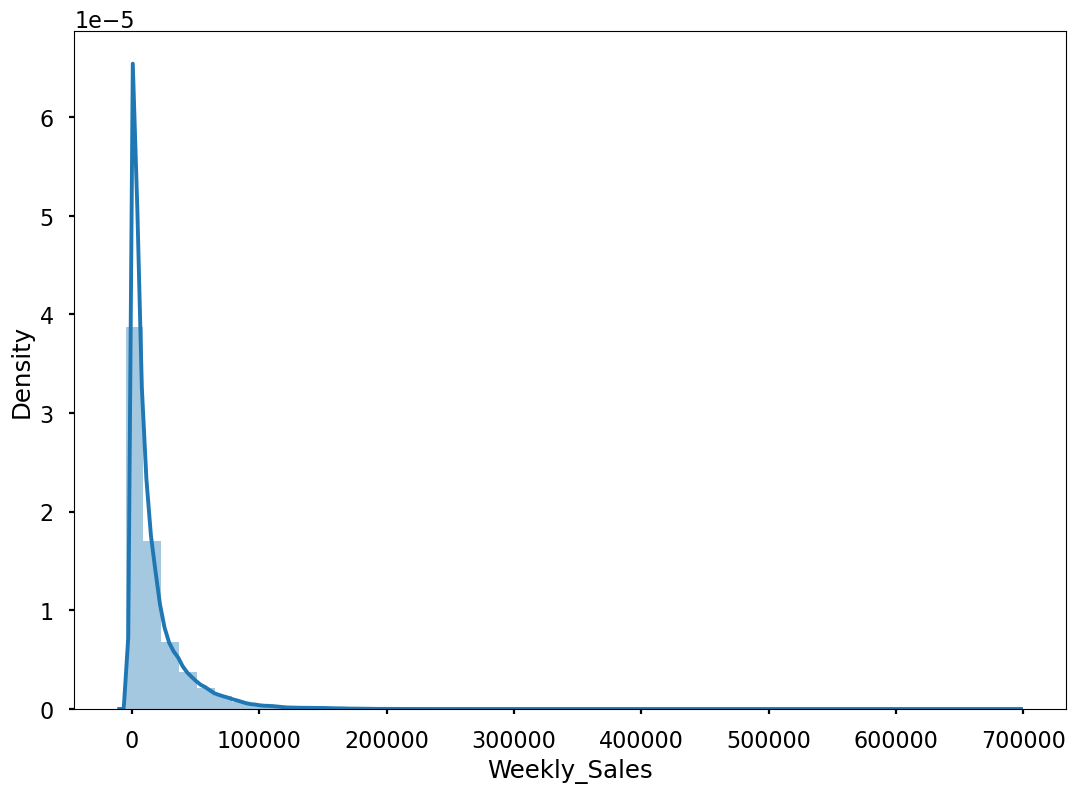

In [155]:
sns.distplot(df['Weekly_Sales'],kde=True)
plt.show()

In [156]:
print('Skewness of the variable are:')
print(df_numeric.skew())

Skewness of the variable are:
Store            0.077763
Dept             0.358223
Weekly_Sales     3.262008
Temperature     -0.321404
Fuel_Price      -0.104901
MarkDown1        4.731304
MarkDown2       10.645956
MarkDown3       14.922341
MarkDown4        8.077666
MarkDown5        9.964519
CPI              0.085219
Unemployment     1.183743
Size            -0.325850
dtype: float64


#### INFERENCE
* As we know, if skew values are <0 left skewed; =0 normally distributed/symetric distribution; >0 right skewed
* We can infer that All 5 Markdowns, Weekly_Sales, CPI and Unemployment are right skewed
* Fuel_Price, Size and Temperature are left skewed
* Comparitively CPI is near normal

In [157]:
print('Kurtosis of the variable are:')
print(df_numeric.kurt())

Kurtosis of the variable are:
Store            -1.146503
Dept             -1.215571
Weekly_Sales     21.491290
Temperature      -0.635922
Fuel_Price       -1.185405
MarkDown1        34.917236
MarkDown2       145.421293
MarkDown3       248.095371
MarkDown4        86.242339
MarkDown5       183.408065
CPI              -1.829714
Unemployment      2.731217
Size             -1.206346
dtype: float64


#### INFERENCE
* As we know if kurt values are <0 platykurtic; =0 mesokurtic; >0 leptokurtic
* We can infer that All 5 Markdowns, Weekly_Sales and Unemployment are leptokurtic
* Fuel_Price, Size, CPI and Temperature are platykurtic

### UNIVARIATE ANALYSIS

* Analysis of Numeric columns

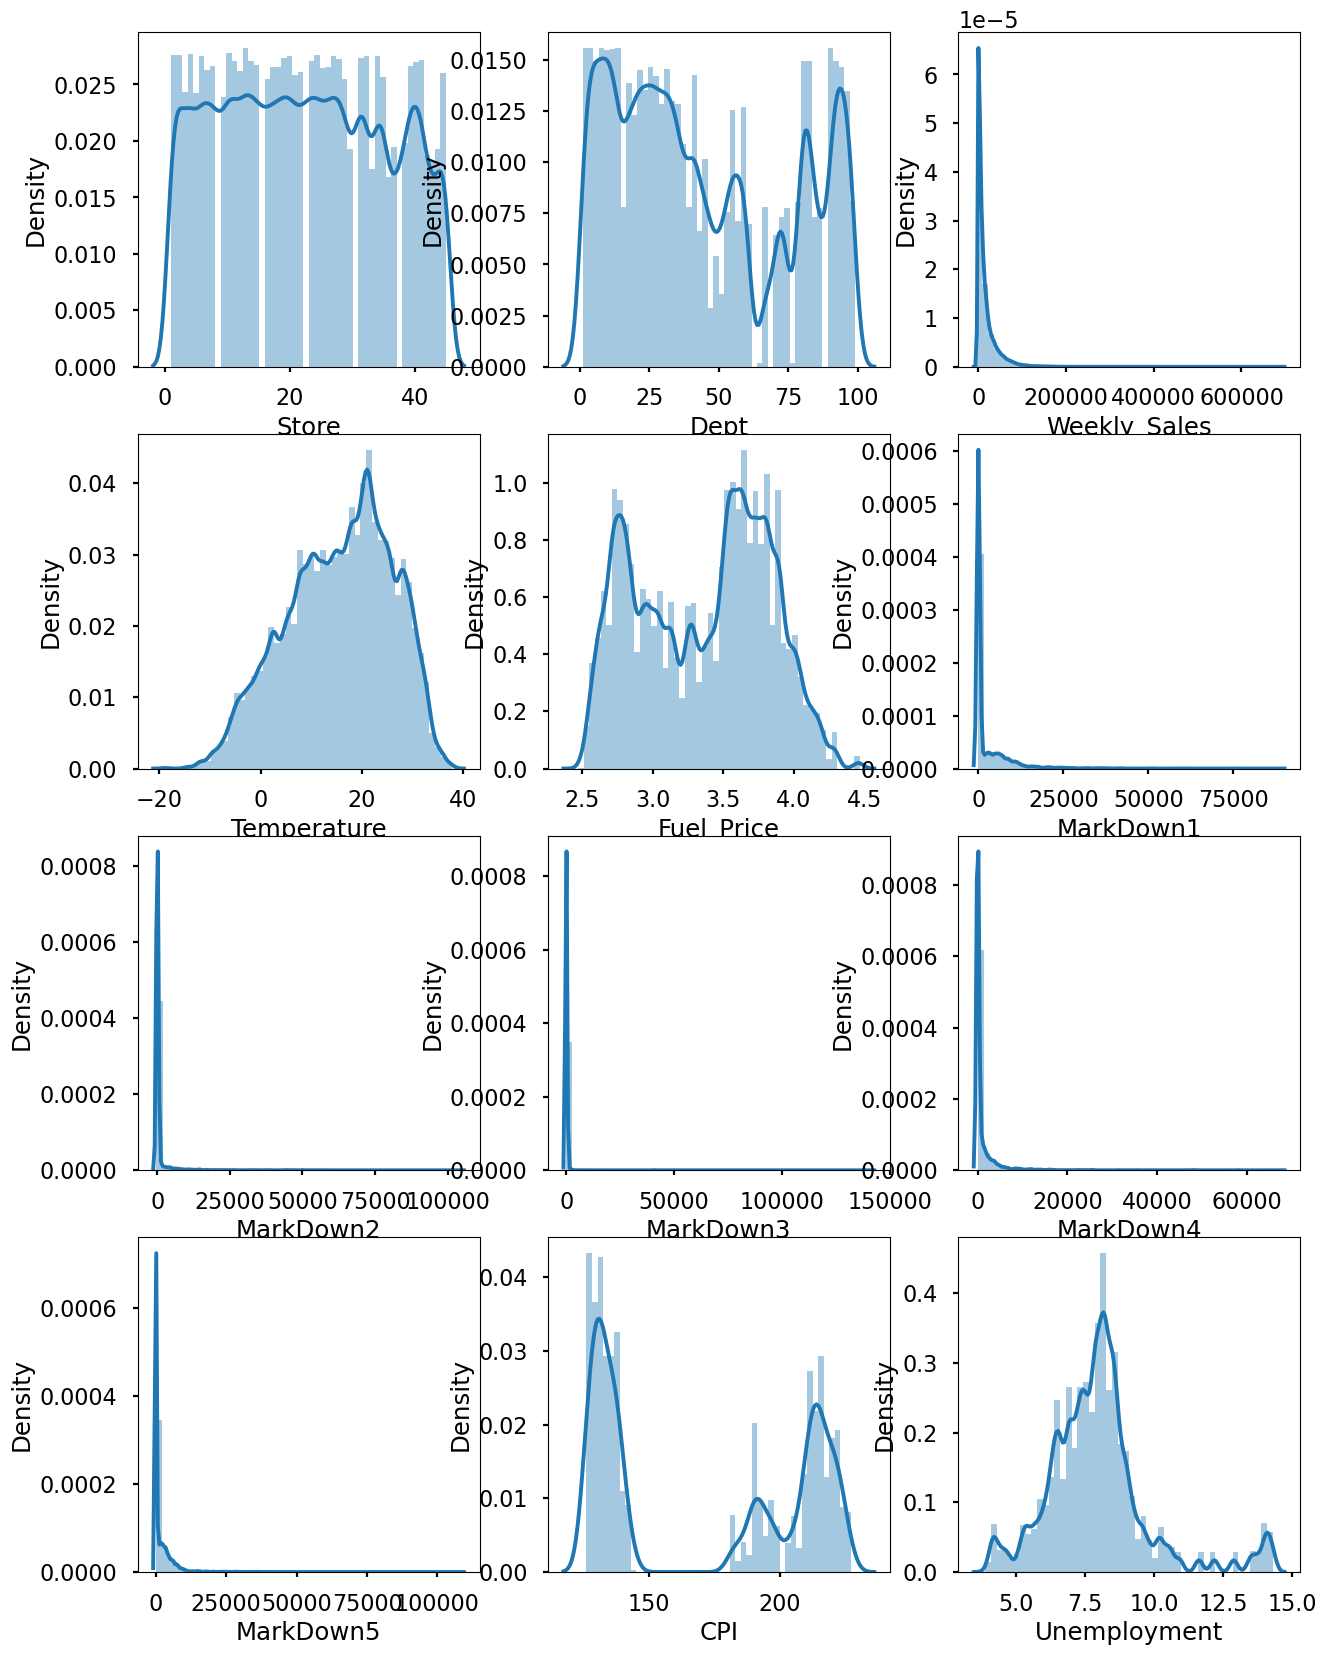

In [158]:
fig, ax = plt.subplots(nrows=4, ncols =3, figsize=(15,20))
for variable, subplot in zip(df_numeric.columns, ax.flatten()):
    sns.distplot(df[variable], kde=True, ax = subplot)
plt.show()

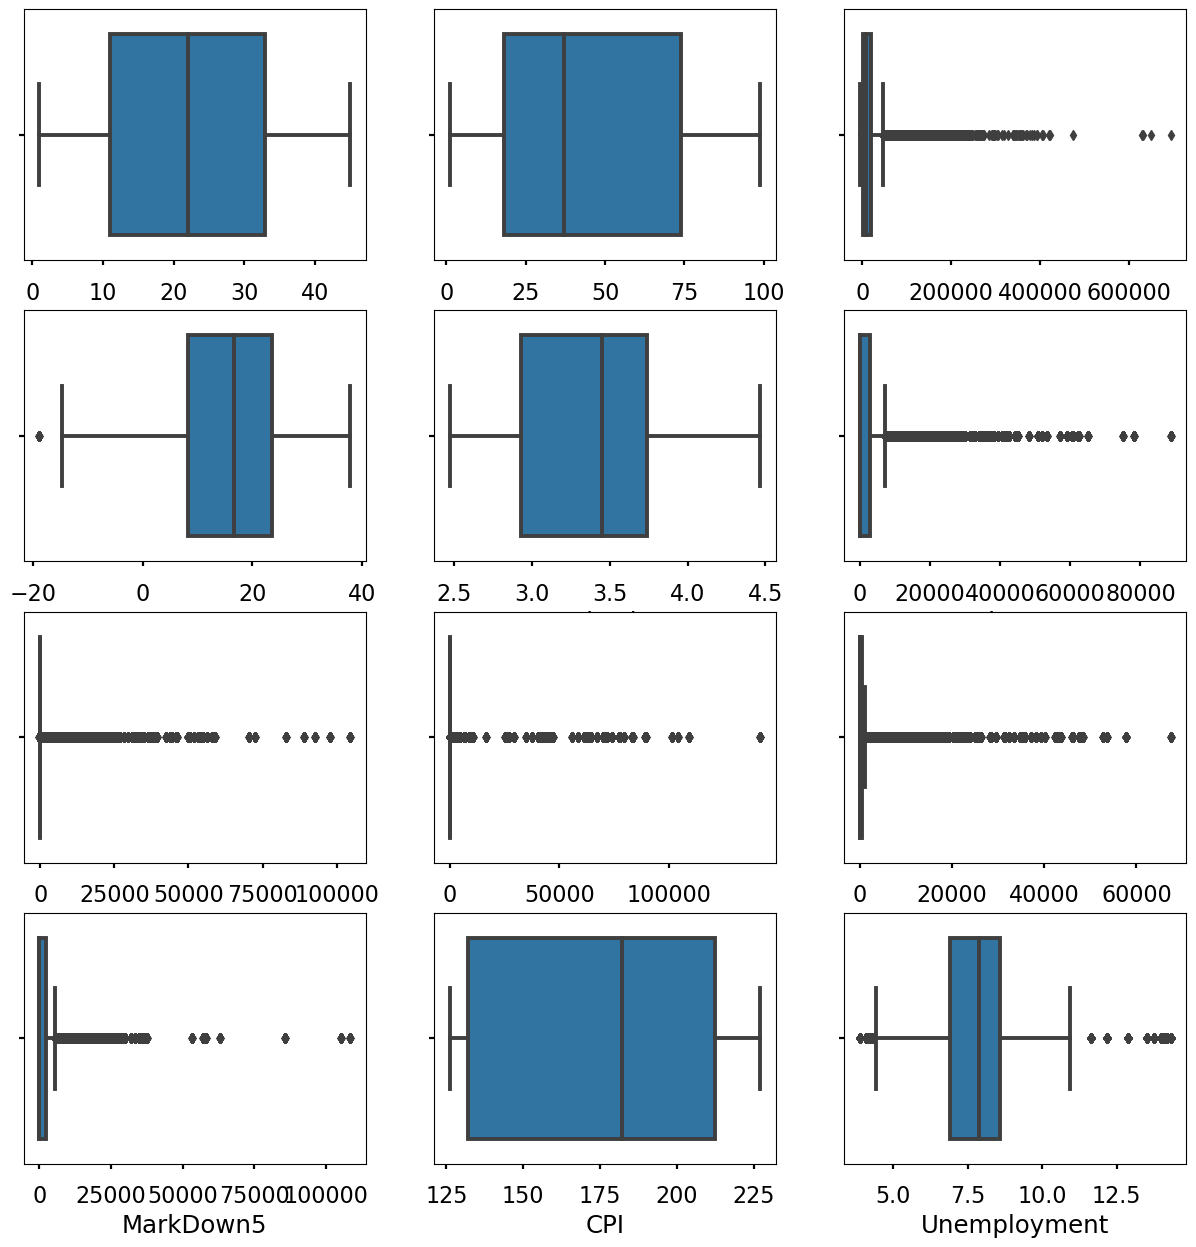

In [159]:
fig, ax = plt.subplots(nrows=4, ncols =3, figsize=(15,15))
for variable, subplot in zip(df_numeric.columns, ax.flatten()):
    sns.boxplot(df[variable], ax = subplot)
plt.show()

In [160]:
df['IsHoliday'] = df['IsHoliday'].astype('object')

### Treating Outliers

* Data shape changed from (421570, 18) to (247244, 18) after outlier treatment

In [161]:
# numeric columns division
df_num=df.select_dtypes(np.number)
df_num.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Size'],
      dtype='object')

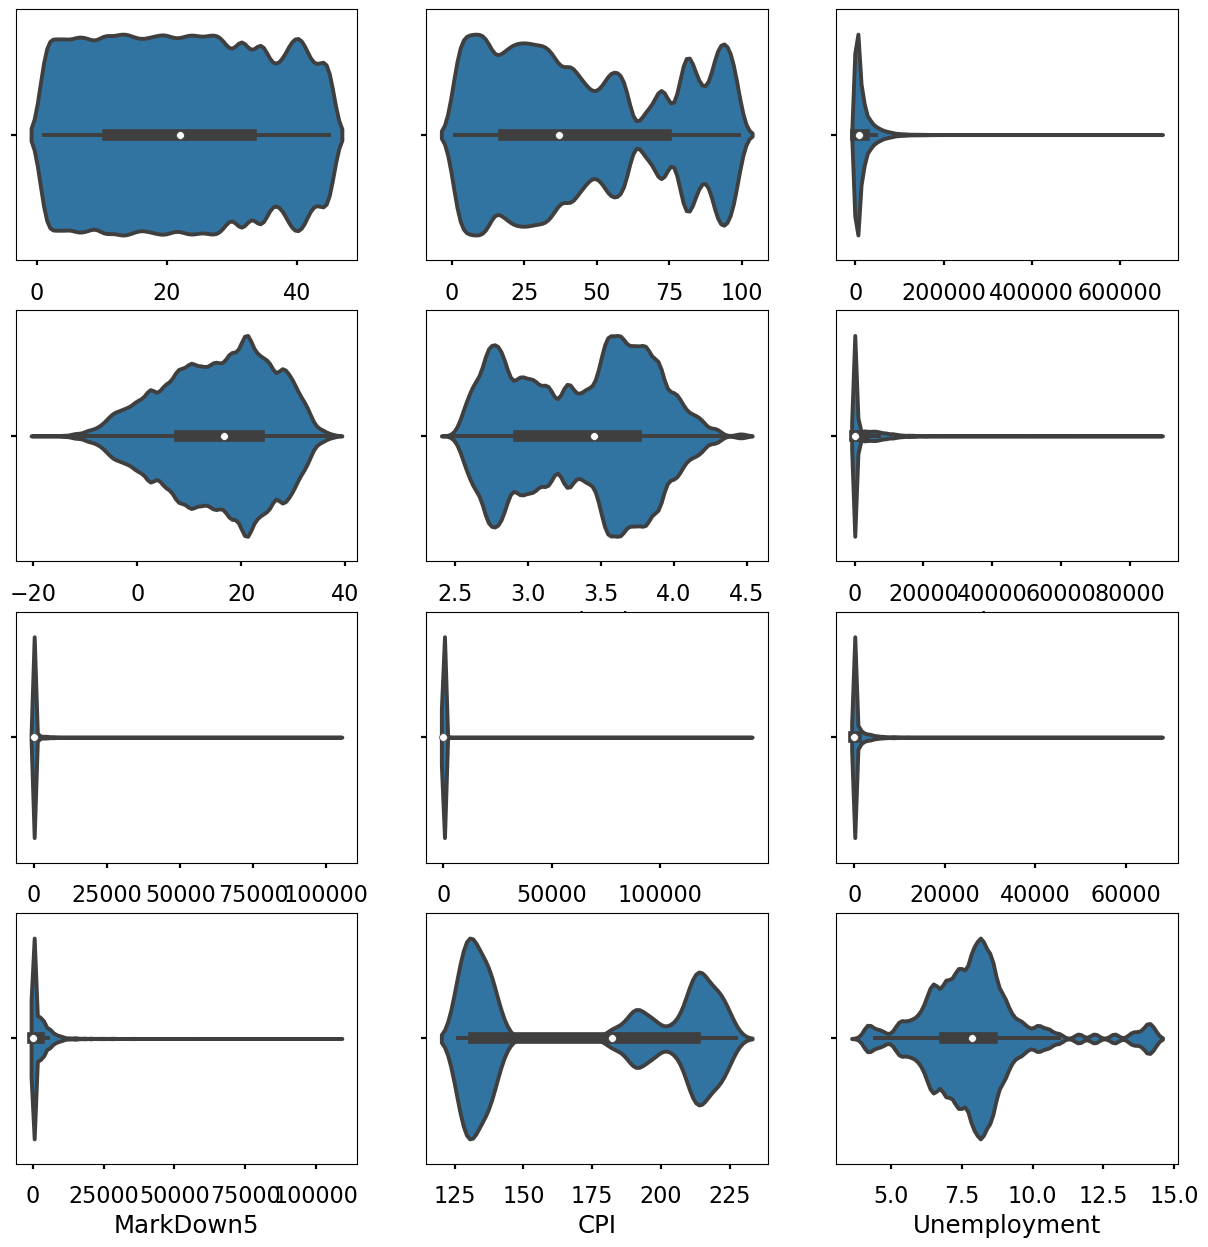

In [162]:
fig, ax = plt.subplots(nrows=4, ncols =3, figsize=(15,15))
for variable, subplot in zip(df_num.columns, ax.flatten()):
    sns.violinplot(df_num[variable], ax = subplot)
plt.show()

fig, ax = plt.subplots(nrows=4, ncols =3, figsize=(15,15))
for variable, subplot in zip(df_num.columns, ax.flatten()):
    sns.swarmplot(df_num[variable], ax = subplot)
plt.show()

fig, ax = plt.subplots(nrows=4, ncols =3, figsize=(15,15))
for variable, subplot in zip(df_num.columns, ax.flatten()):
    sns.stripplot(df_num[variable], ax = subplot)
plt.show()

In [163]:
df_cat = df.select_dtypes(include='object')
df_cat.columns

Index(['IsHoliday', 'Type'], dtype='object')

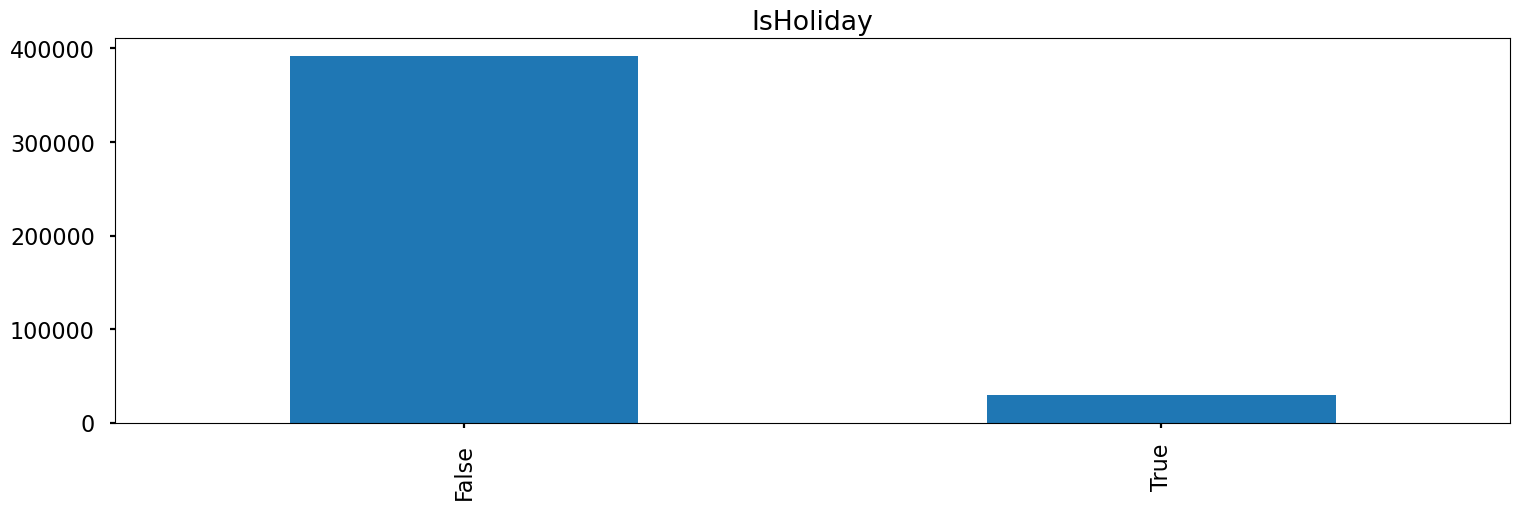

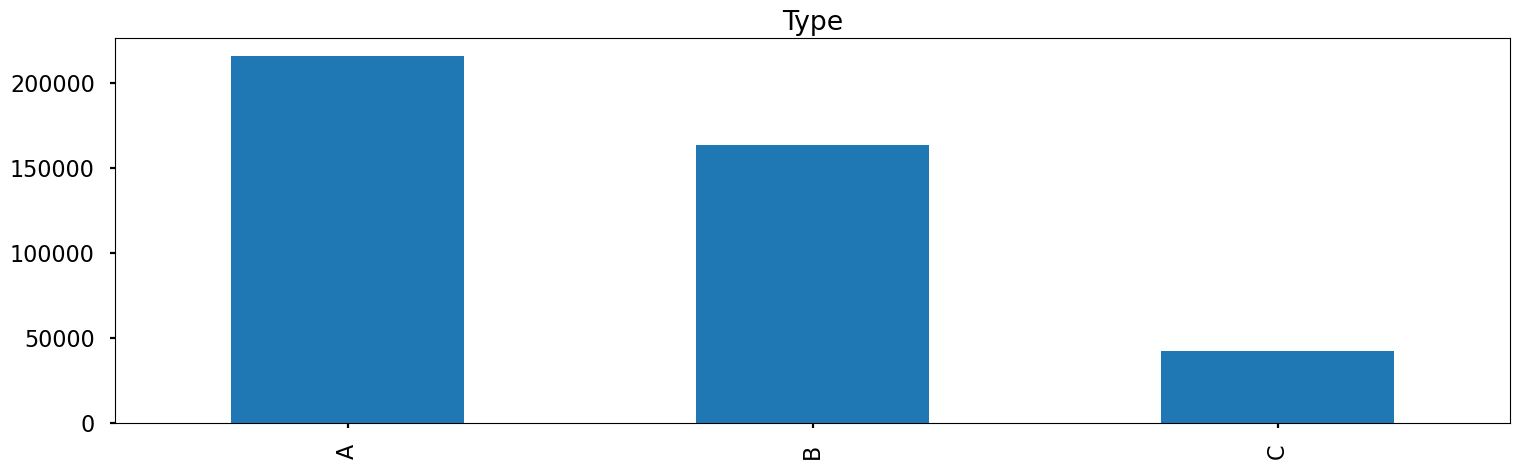

In [164]:
for i in df_cat.columns:
    plt.figure(figsize=(18,5))
    df_cat[i].value_counts().plot(kind='bar')
    plt.title('{}'.format(i))
    plt.show()

## Bivariate Analysis

In [165]:
# Numerical vs Numerical

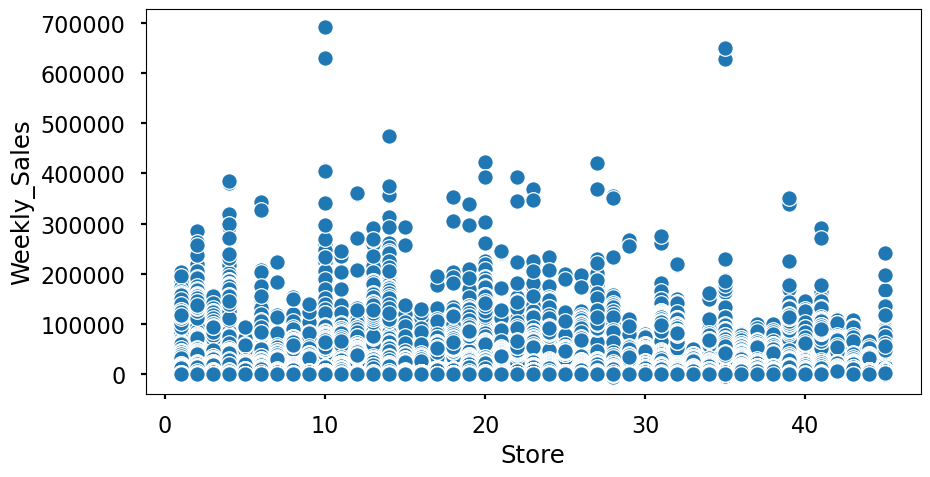

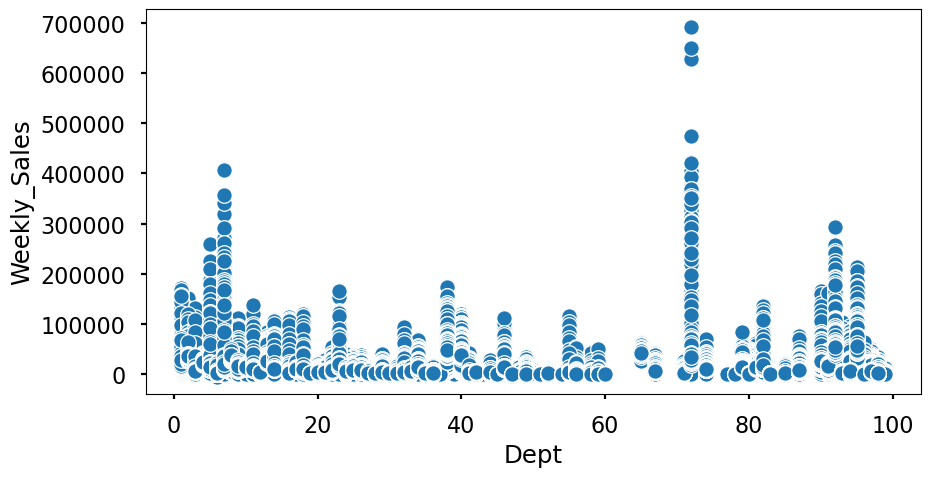

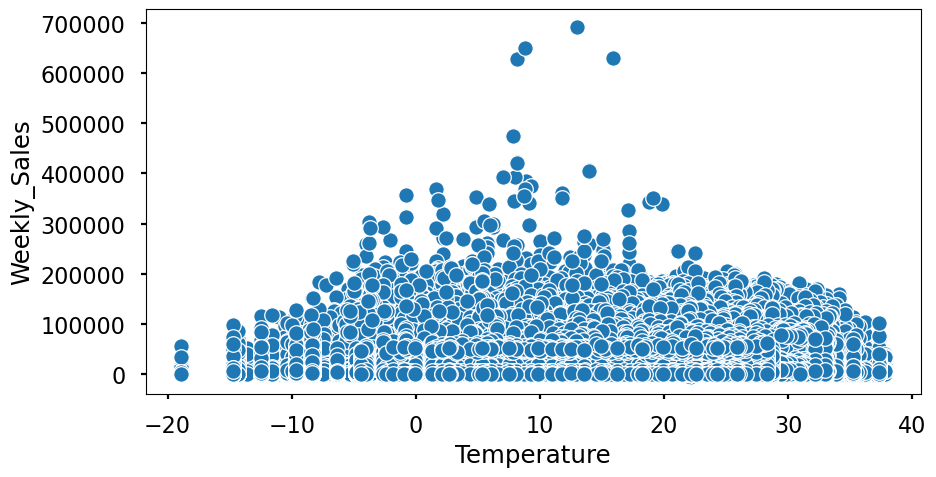

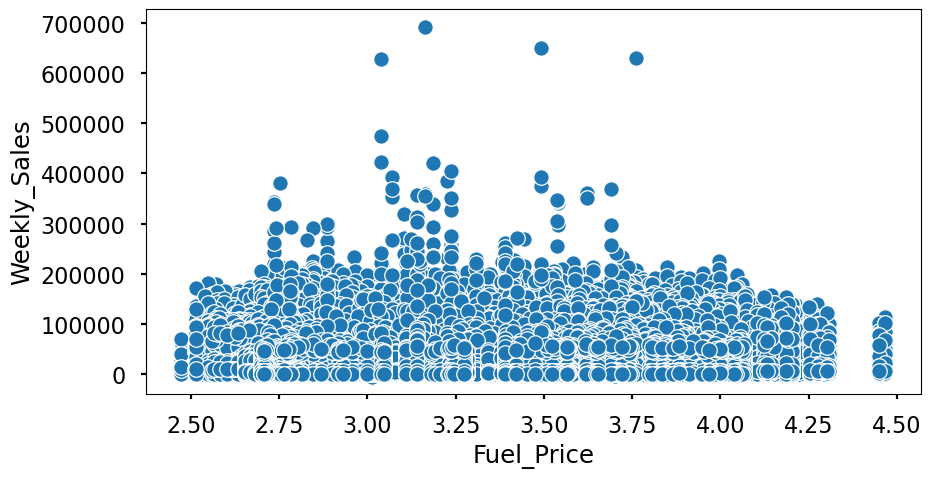

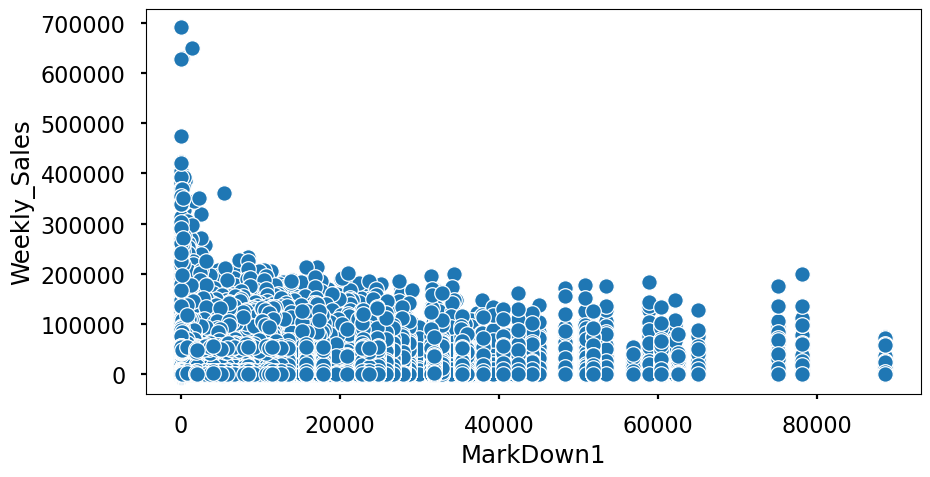

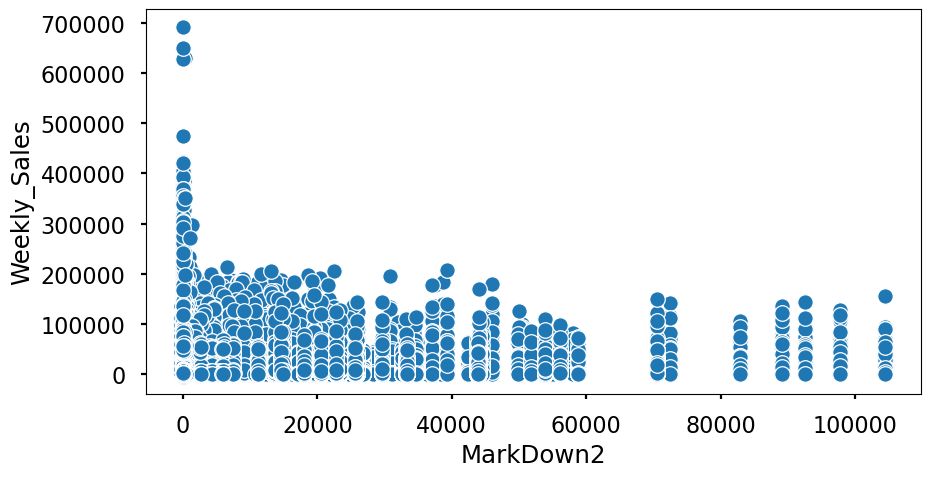

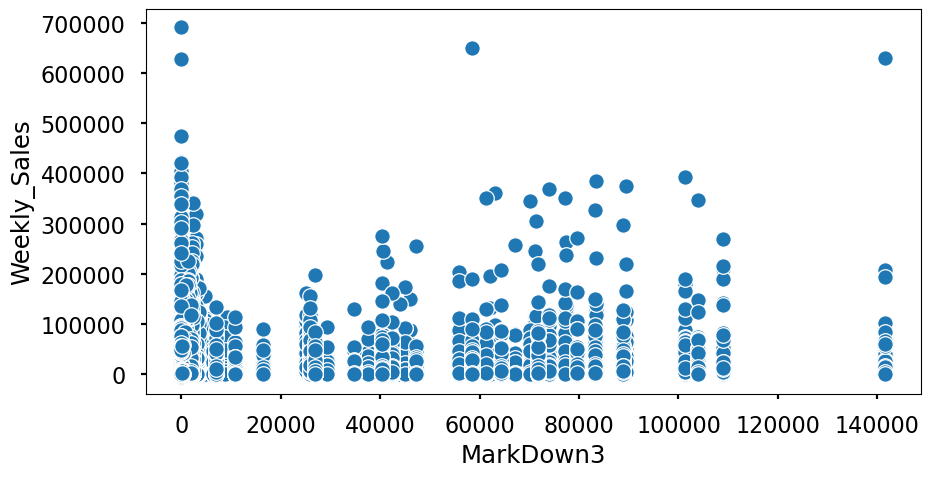

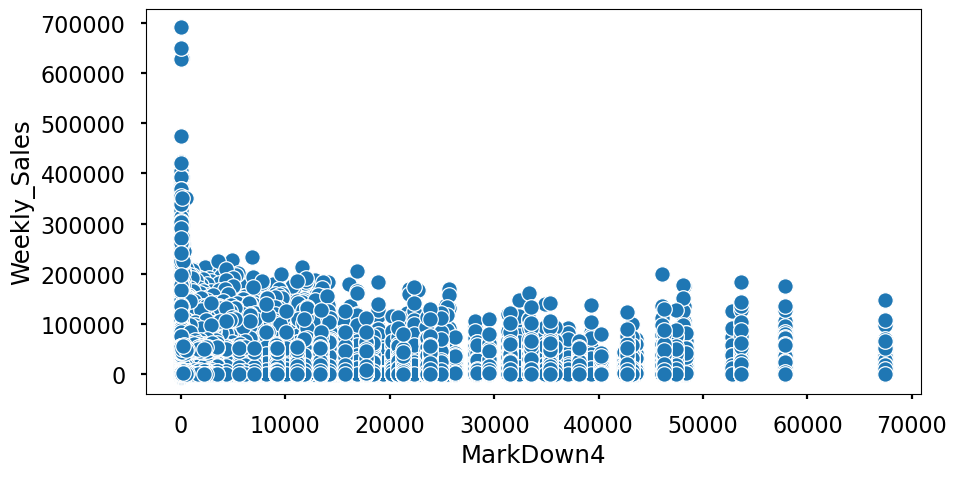

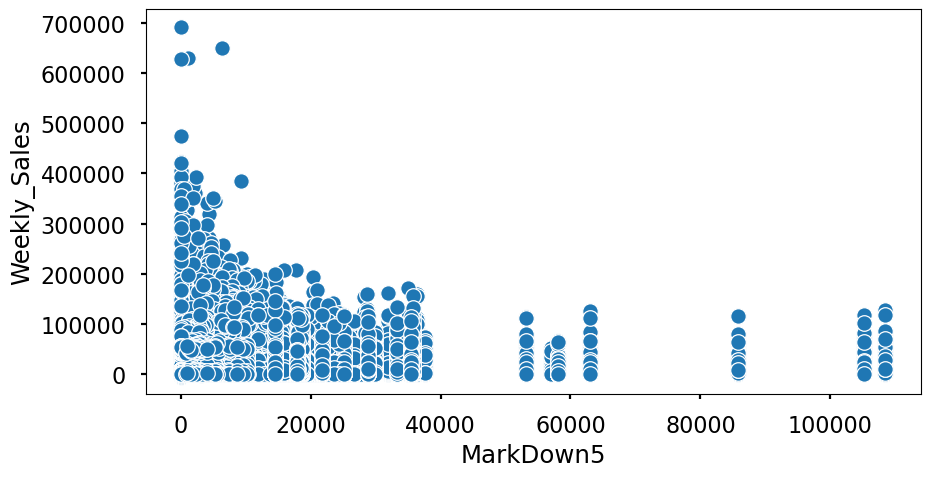

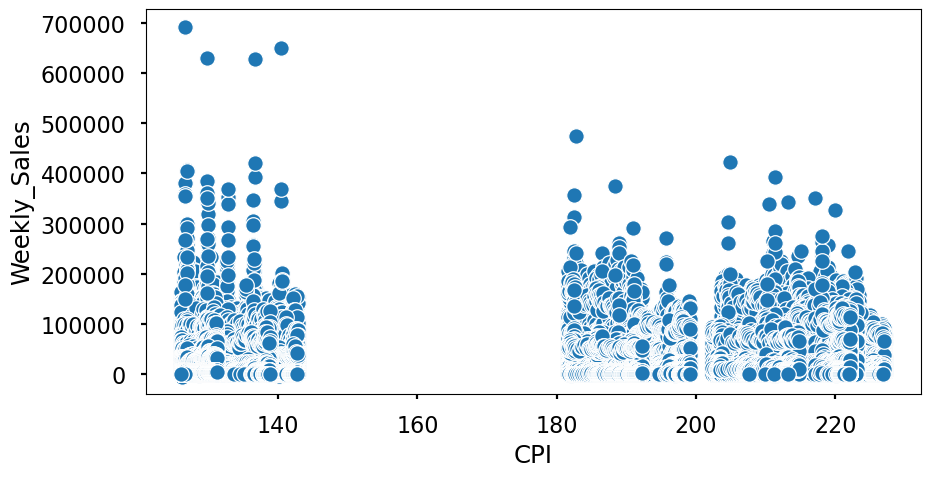

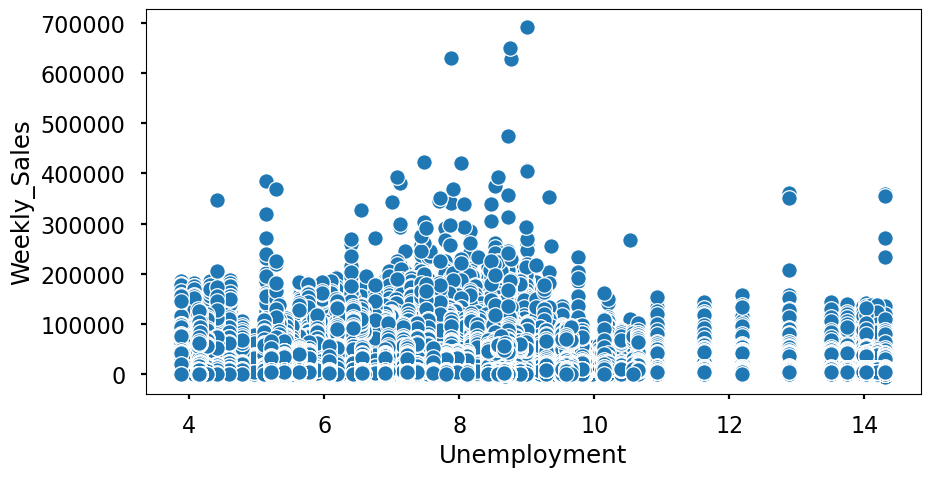

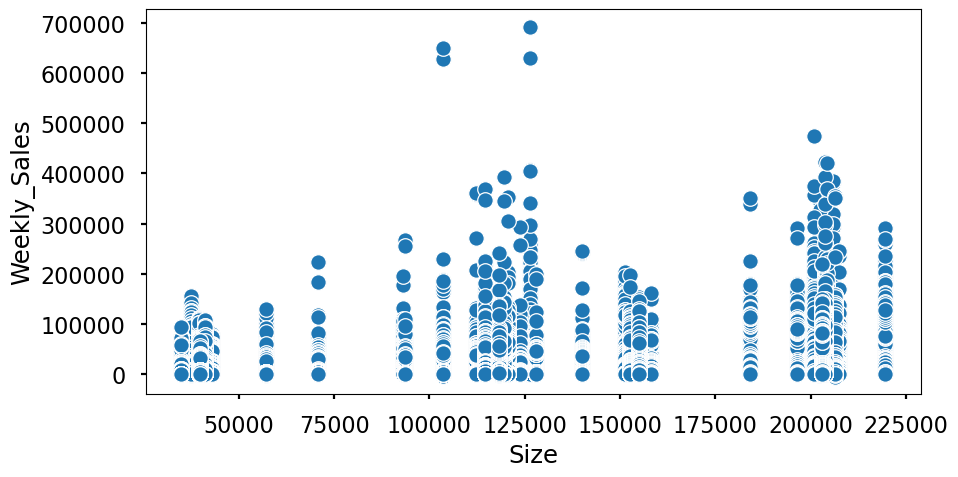

In [166]:
num=df_num.drop('Weekly_Sales', axis=1)
for i in num:
    plt.figure(figsize=(10,5))
    sns.scatterplot(x =i, y ='Weekly_Sales', data = df_numeric)
    plt.show()

In [167]:
# Numerical vs Catogorical :

In [168]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [169]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)

In [170]:
df_cat.columns

Index(['IsHoliday', 'Type'], dtype='object')

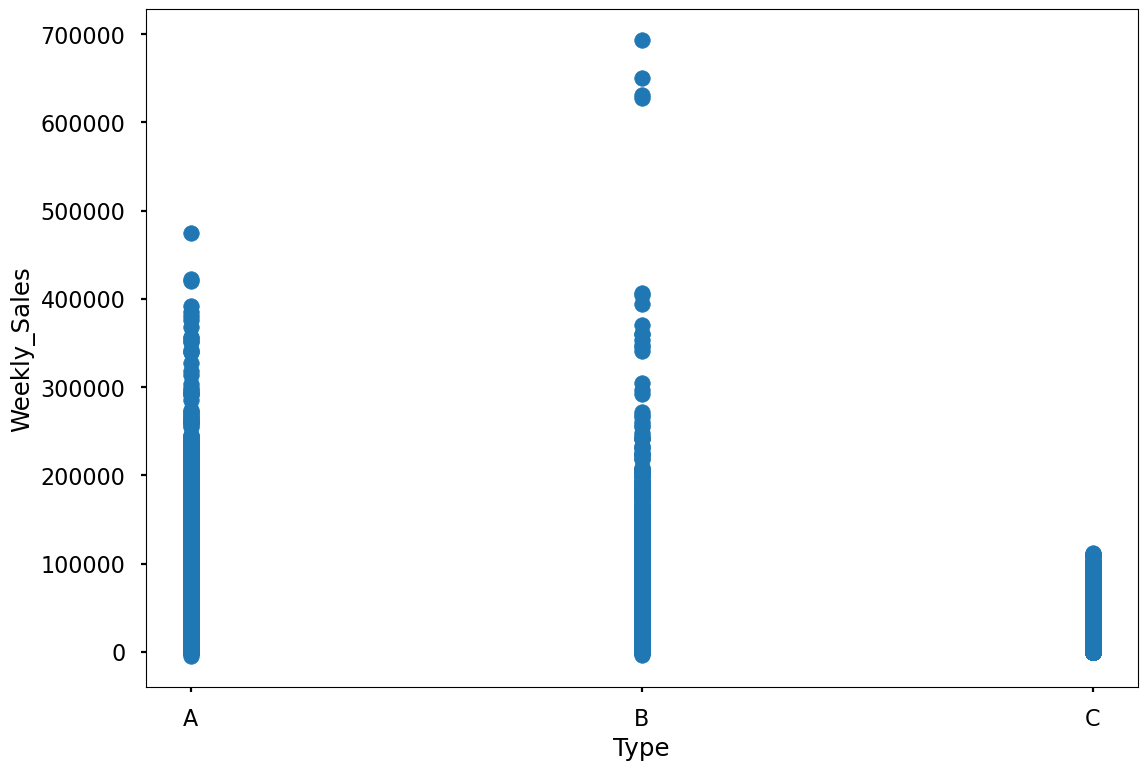

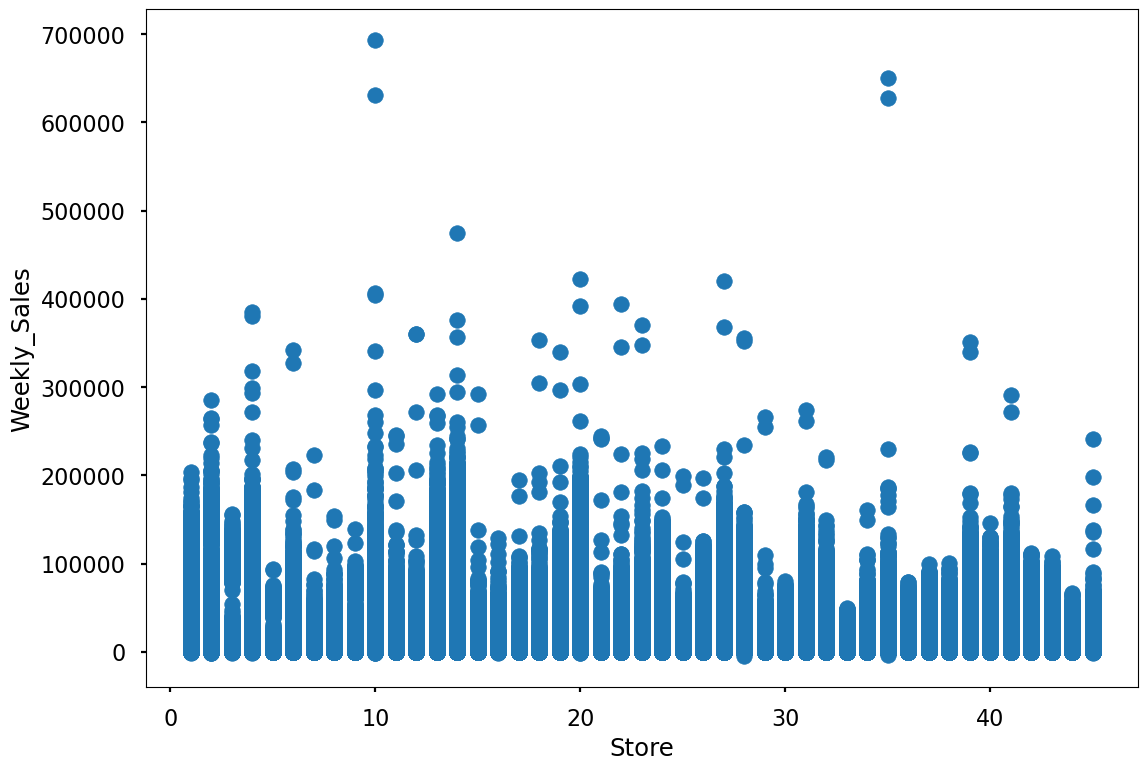

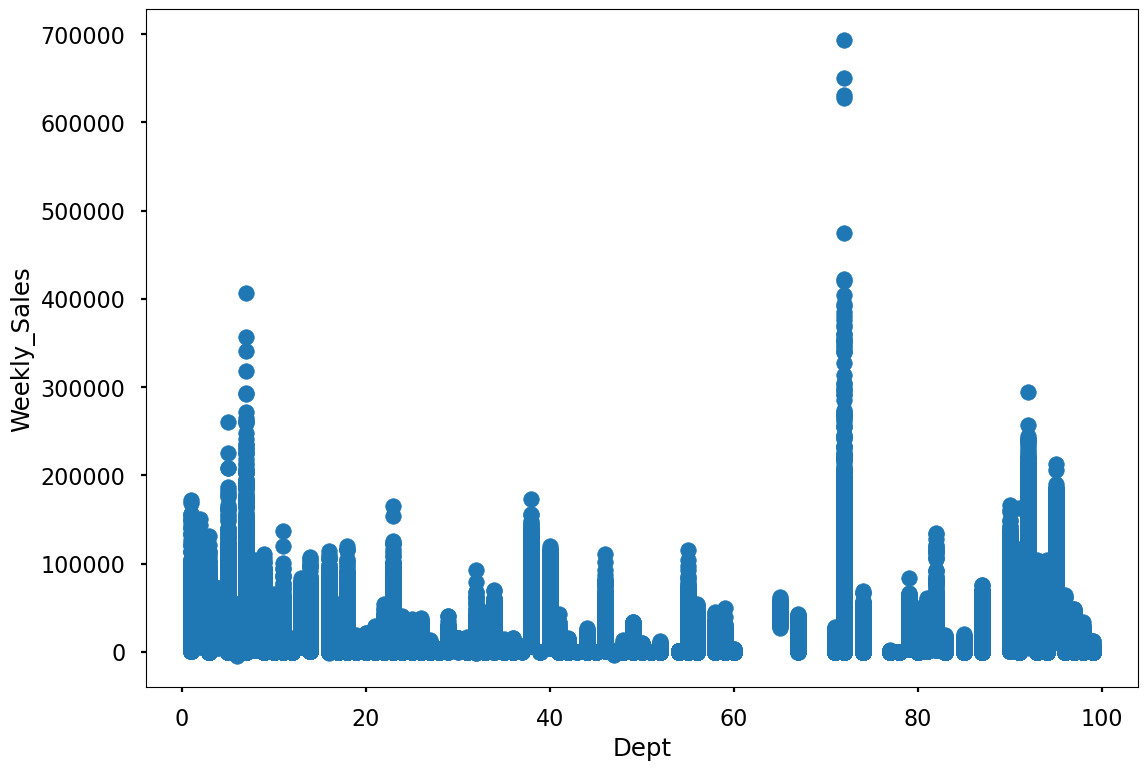

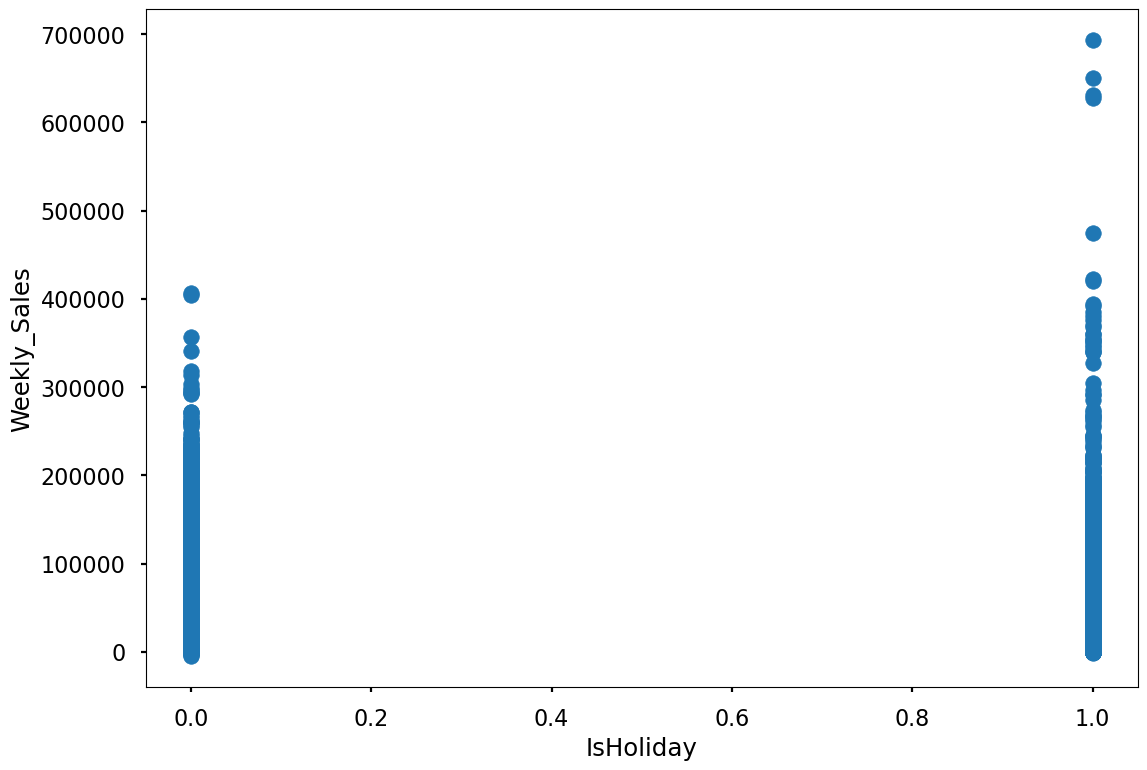

In [171]:
scatter(df, 'Type')
scatter(df, 'Store')
scatter(df, 'Dept')
scatter(df, 'IsHoliday')

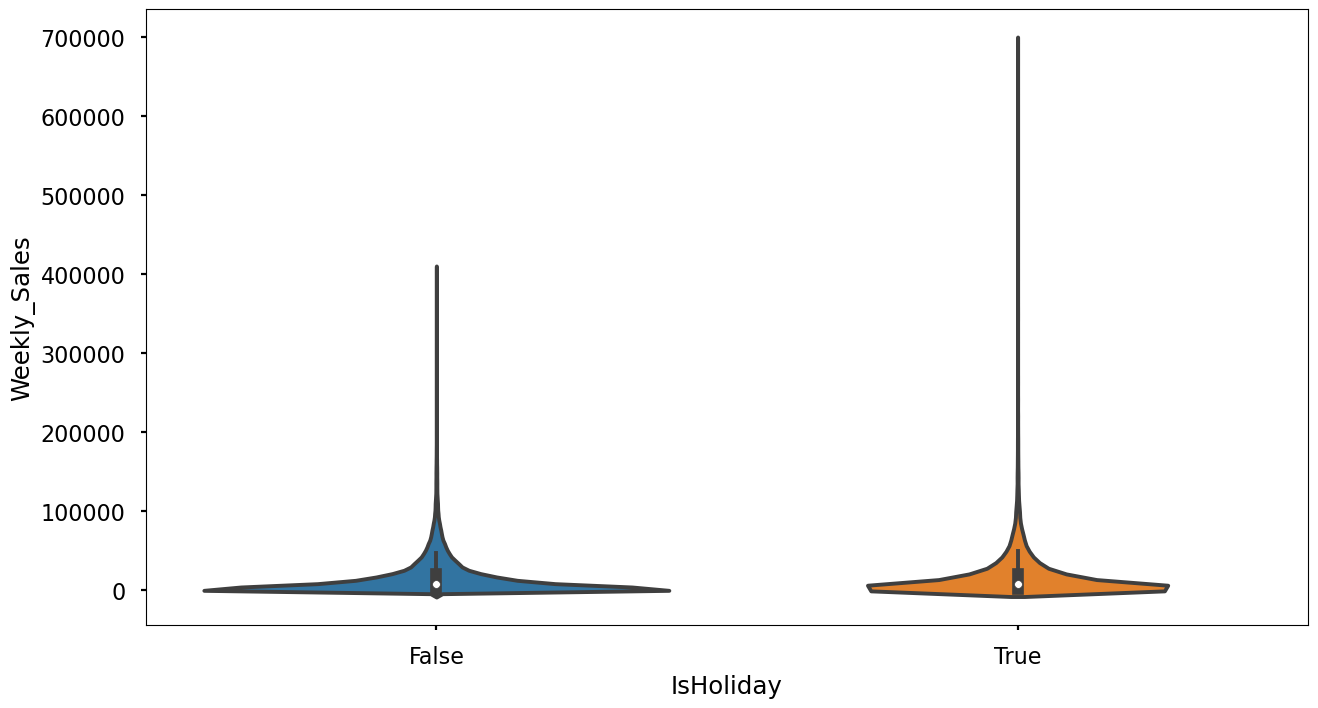

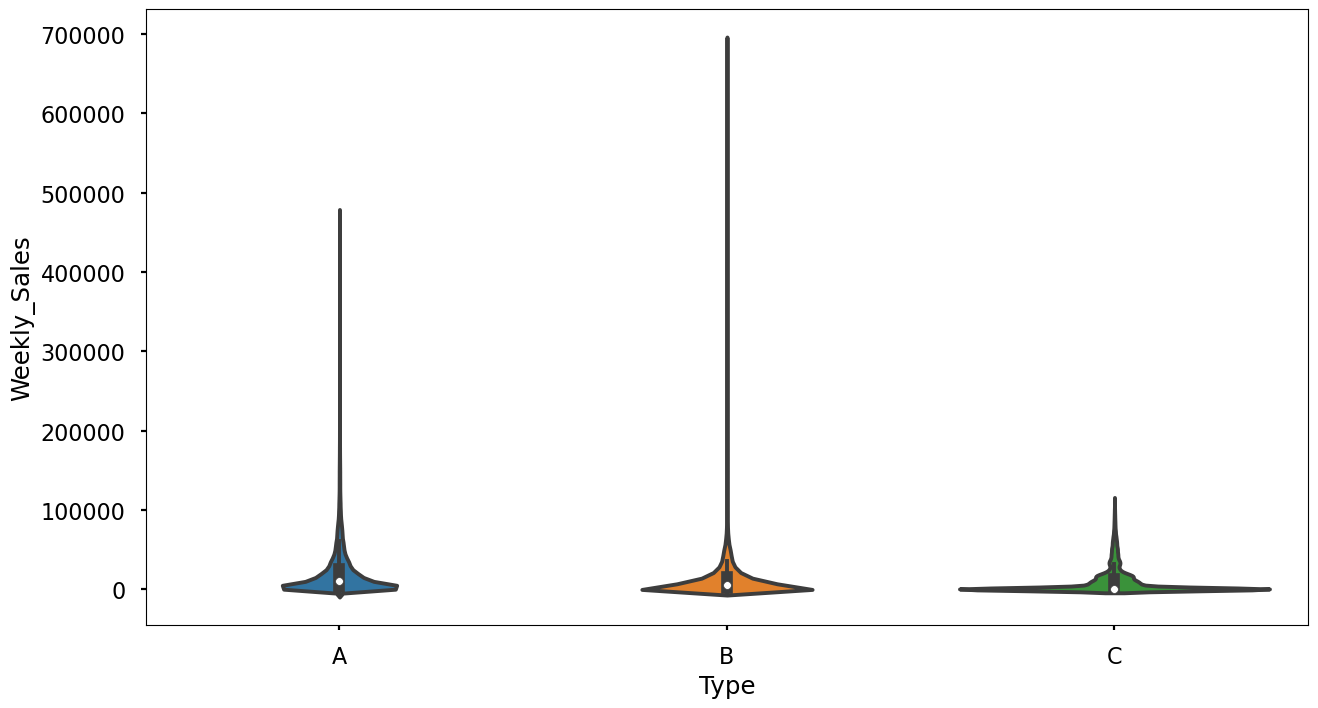

In [172]:
for i in df_cat.columns:
    plt.figure(figsize=(15,8))
    sns.violinplot(x =i, y ='Weekly_Sales', data = df)
    plt.show()

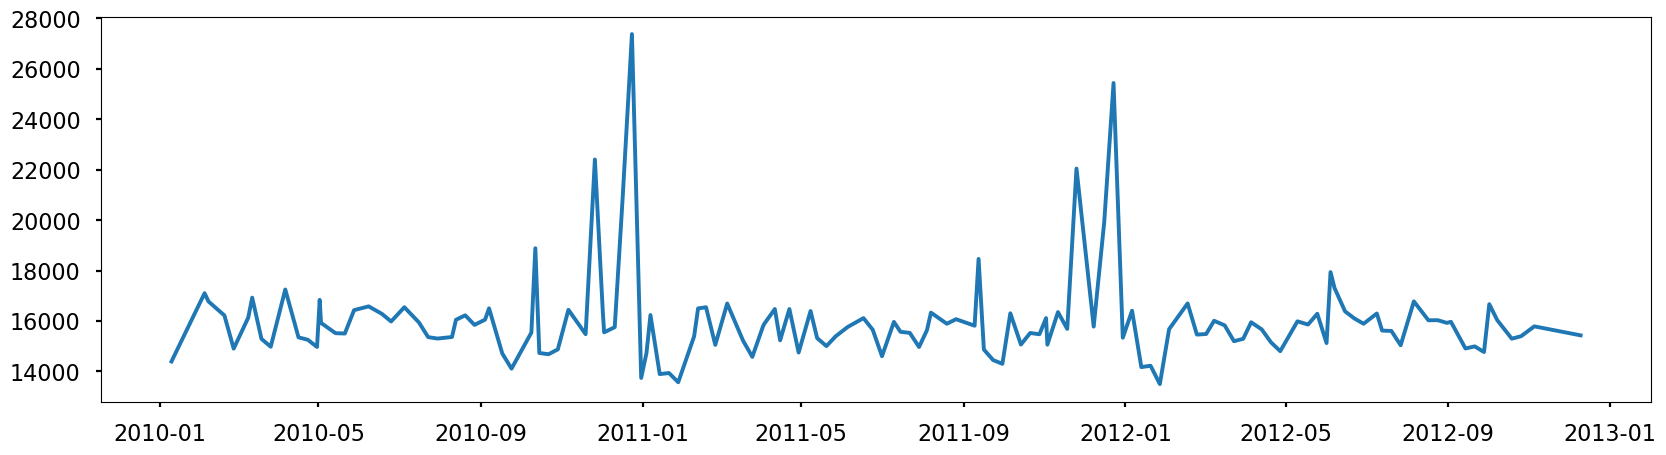

In [173]:
df_average_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].mean()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
plt.show()

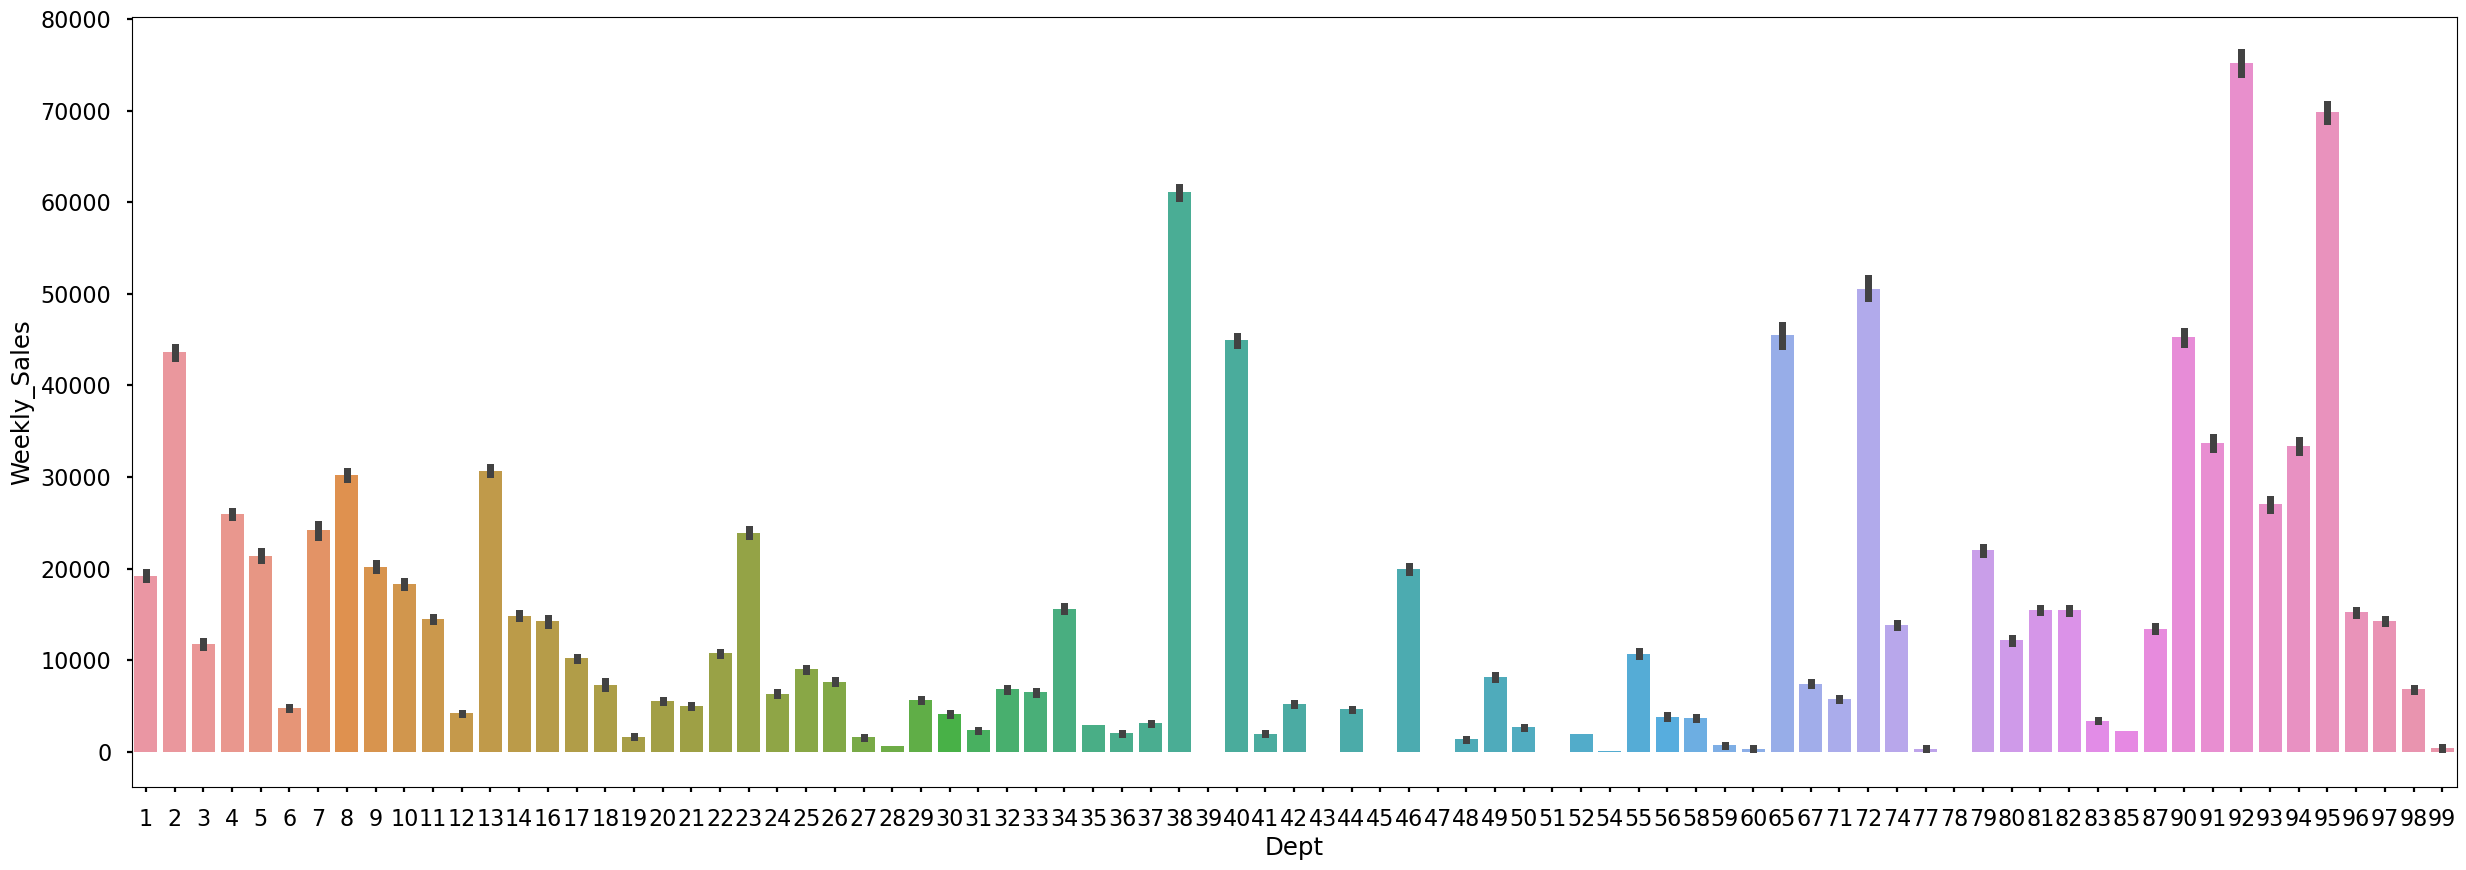

In [174]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

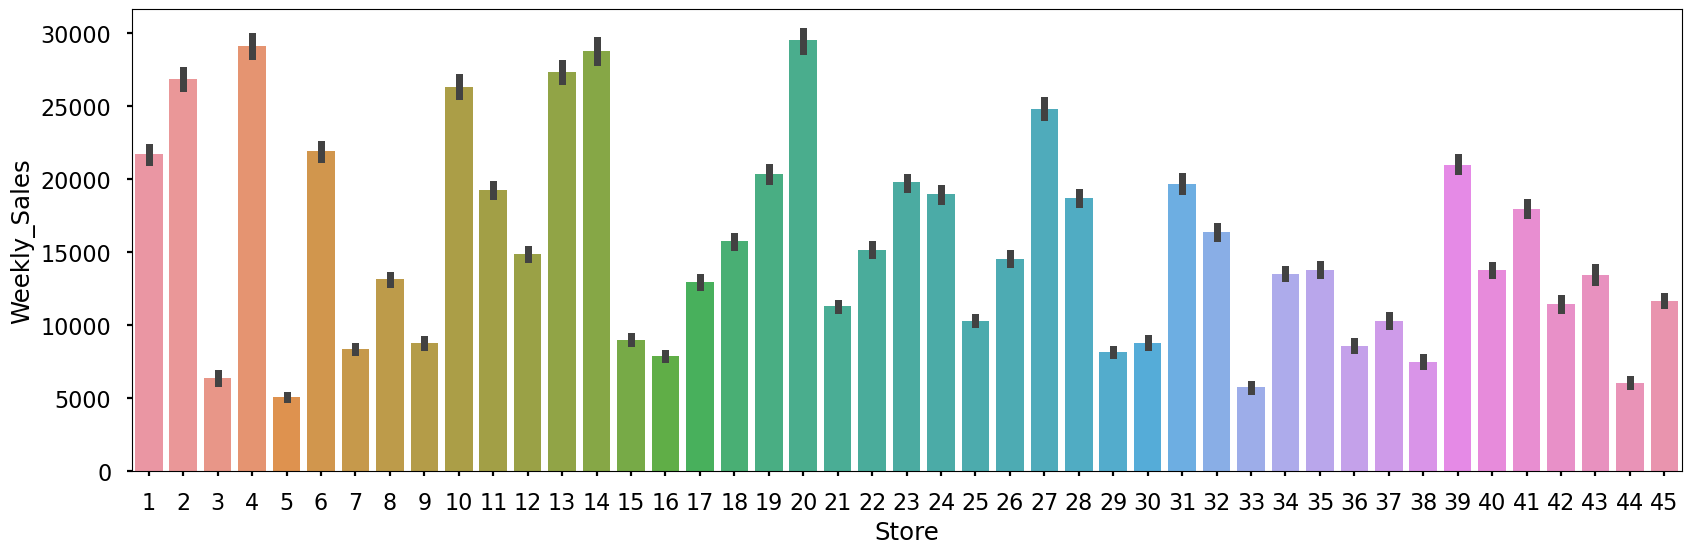

In [175]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

### MULTIVARIATE ANALYSIS

<AxesSubplot:>

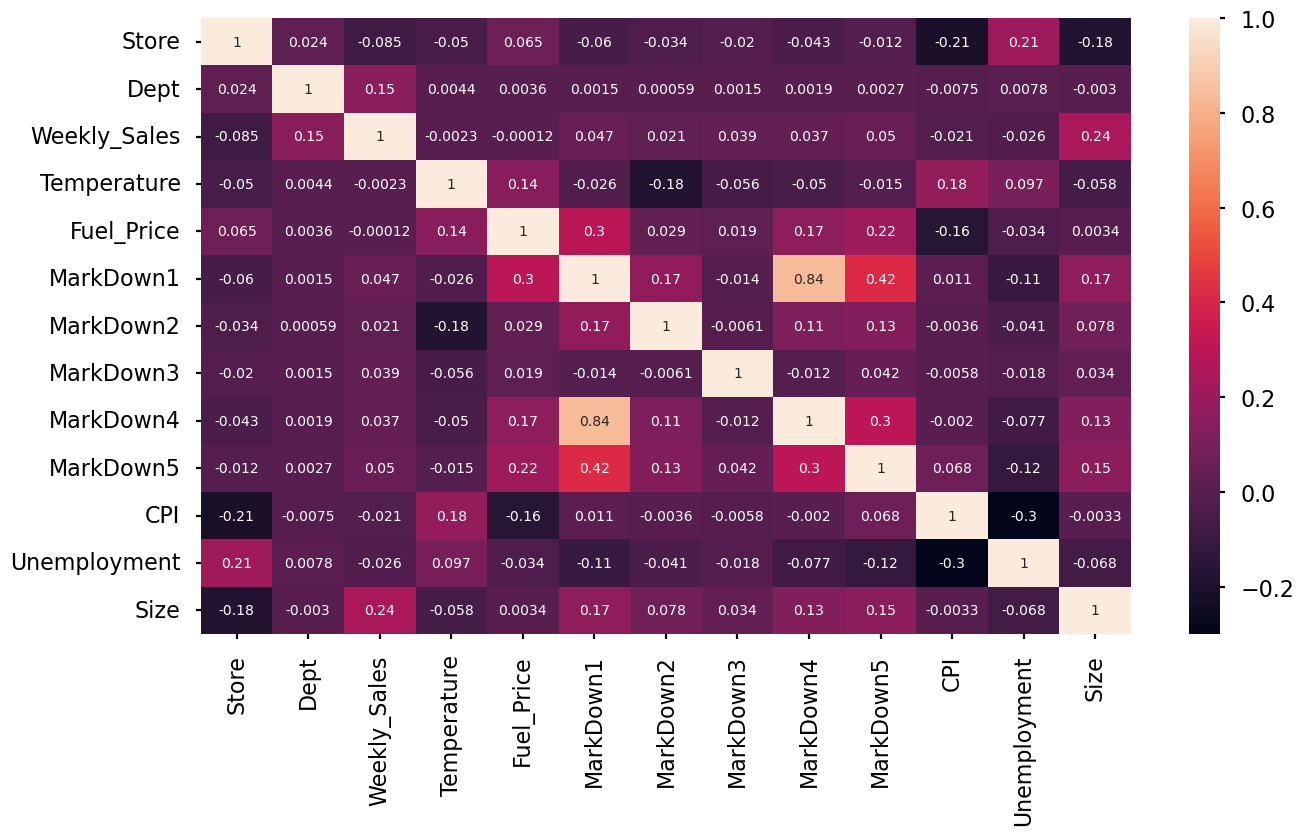

In [176]:
plt.figure(figsize=(15,8))
sns.heatmap(df_num.corr(),annot=True)

#### INFERENCE
* This shows that there is high correlation between the Markdowns columns
* There is no significant relationship of any columns except size with our target variable viz., Weekly_Sales which implies there is high multicollinearity, autocorrelation; So, we are proceeding with OLS model to check the multicollinearity with Condition Number and look for a more solid inference

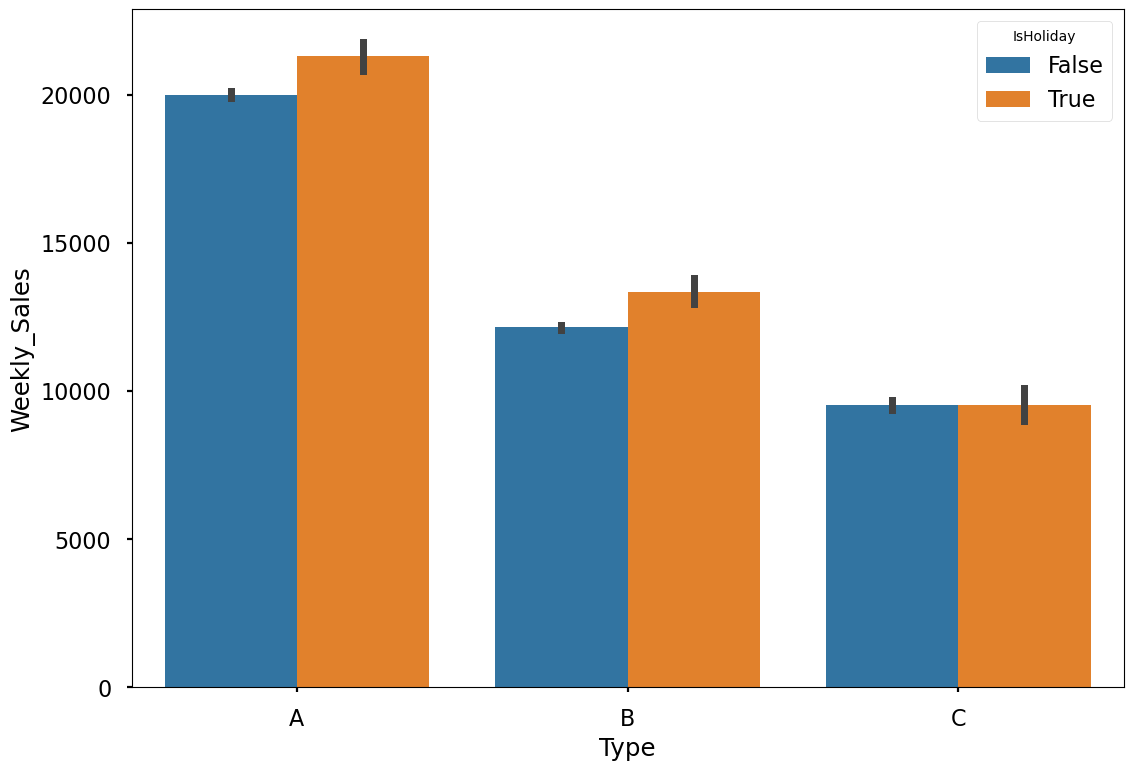

In [177]:
# plot between 2 categorical (IsHoliday & Type) and one numerical column(Weekly_Sales)
sns.barplot(x='Type', y='Weekly_Sales', hue='IsHoliday', data=df)
plt.show()

- There very Less Increase in Weekly Sales with the occurance of Holdiday in the week.
- This pattern can be observed among all three types of Stores.

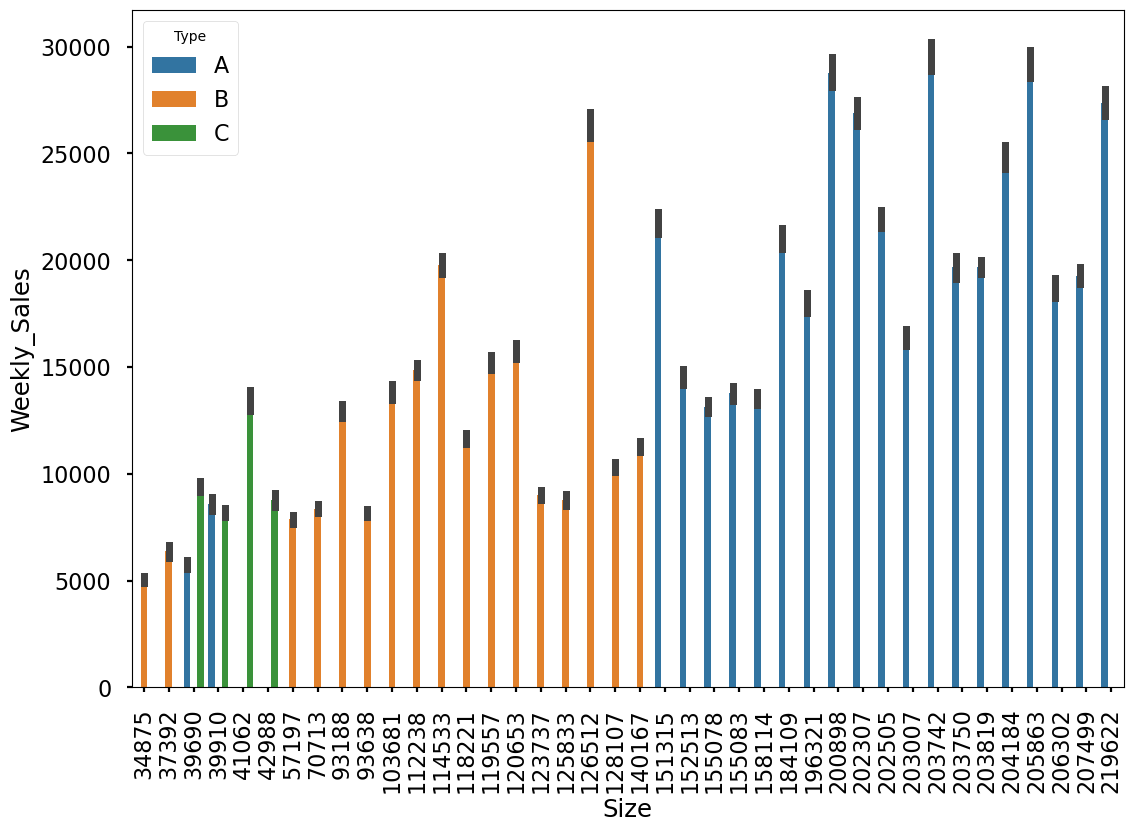

In [178]:
sns.barplot(x=df['Size'].sort_values(), y='Weekly_Sales', hue='Type', data=df)
plt.xticks(rotation=90)
plt.show()

### Feature Engineering

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

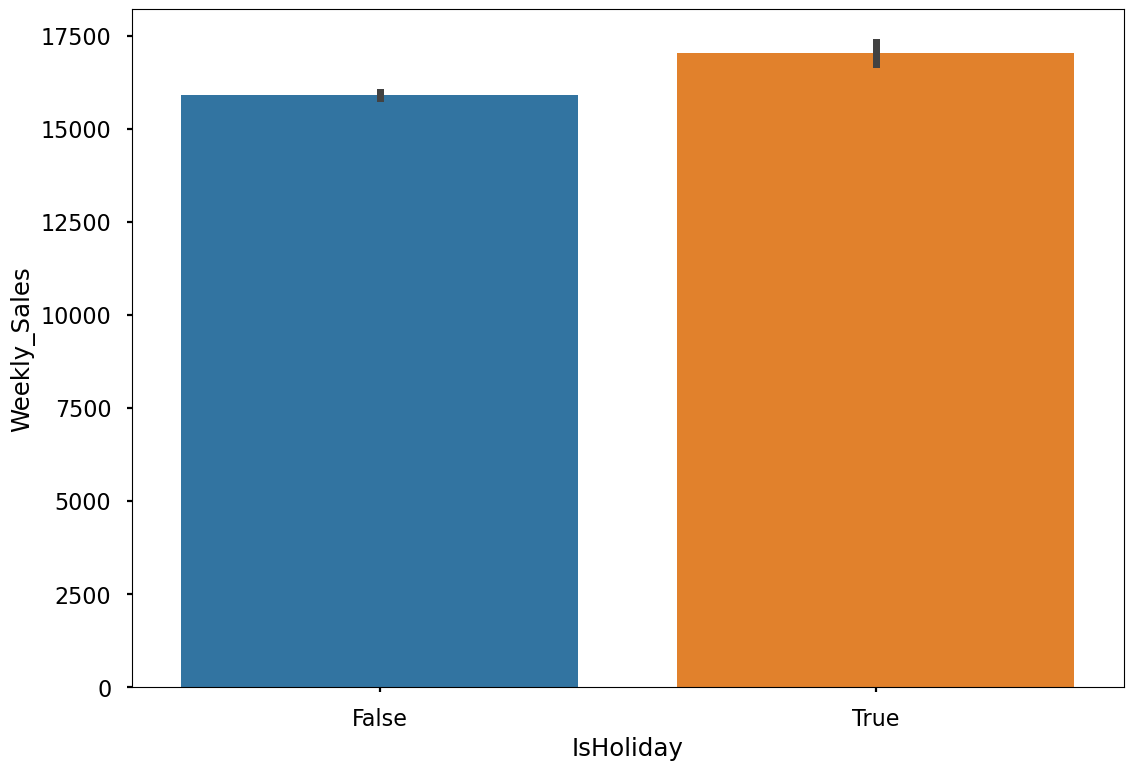

In [179]:
# IsHoliday
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [180]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-12-02T00:00:00.000000000', '2010-10-09T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-11-02T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-10-02T00:00:00.000000000', '2012-07-09T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [181]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

We want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [182]:
# Super bowl dates in data set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10')|(df['Date'] == '2013-02-08'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10')&(df['Date'] != '2013-02-08'),'Super_Bowl'] = False

In [183]:
# Labor day dates in data set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07')|(df['Date'] == '2013-09-06'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07')&(df['Date'] != '2013-09-06'),'Labor_Day'] = False

In [184]:
# Thanksgiving dates in data set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25')|(df['Date'] == '2012-11-23')|(df['Date'] == '2013-11-29'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25')&(df['Date'] != '2012-11-23')&(df['Date'] != '2013-11-29'),'Thanksgiving'] = False

In [185]:
#Christmas dates in data set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30')|(df['Date'] == '2012-12-28')|(df['Date'] == '2013-12-27'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30')&(df['Date'] != '2012-12-28')&(df['Date'] != '2013-12-27'),'Christmas'] = False

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

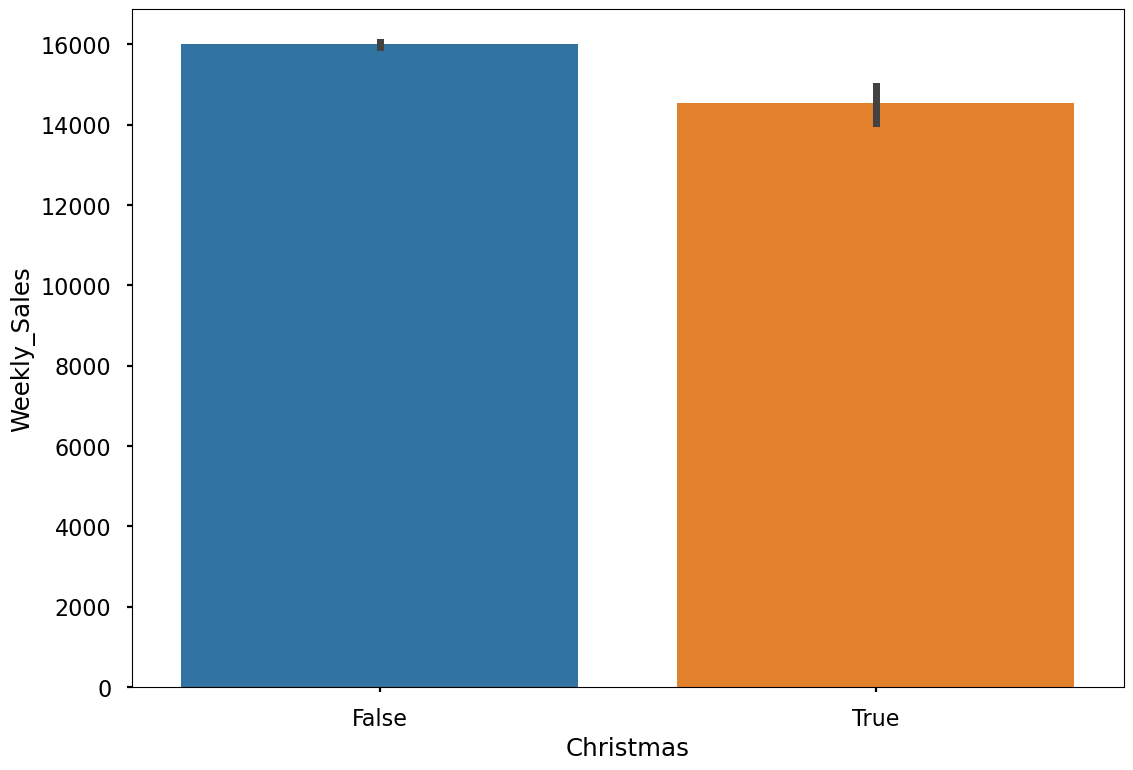

In [186]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

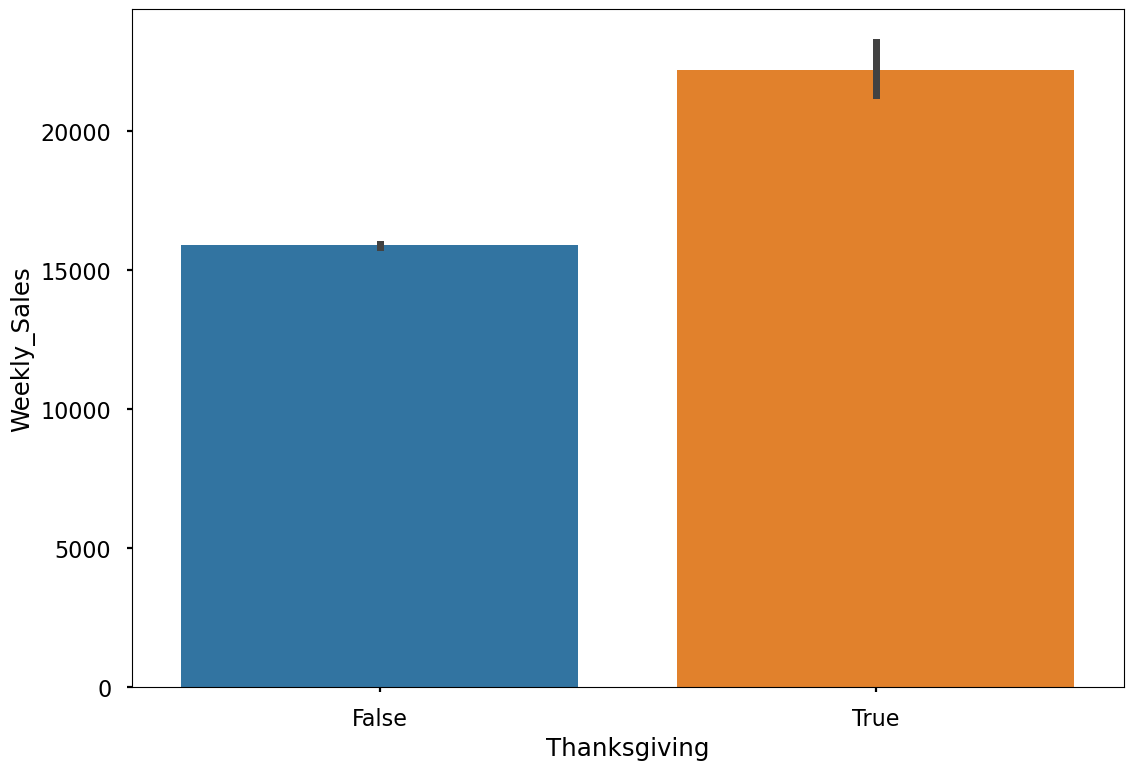

In [187]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

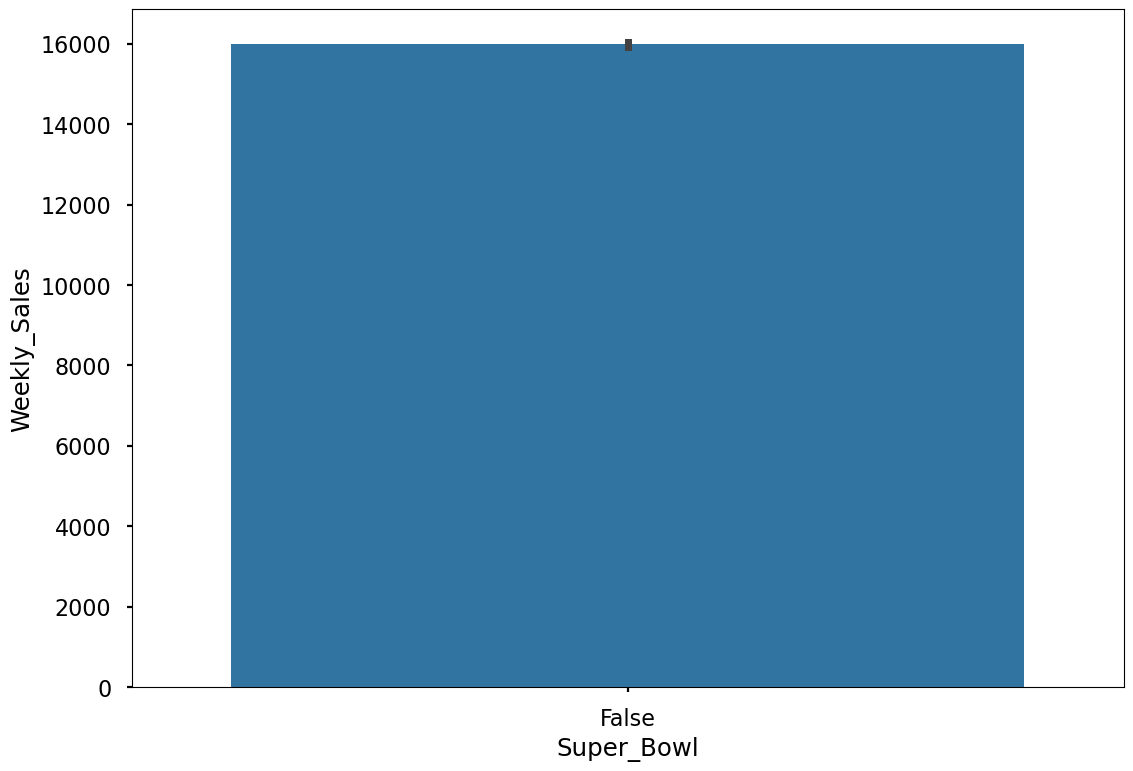

In [188]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

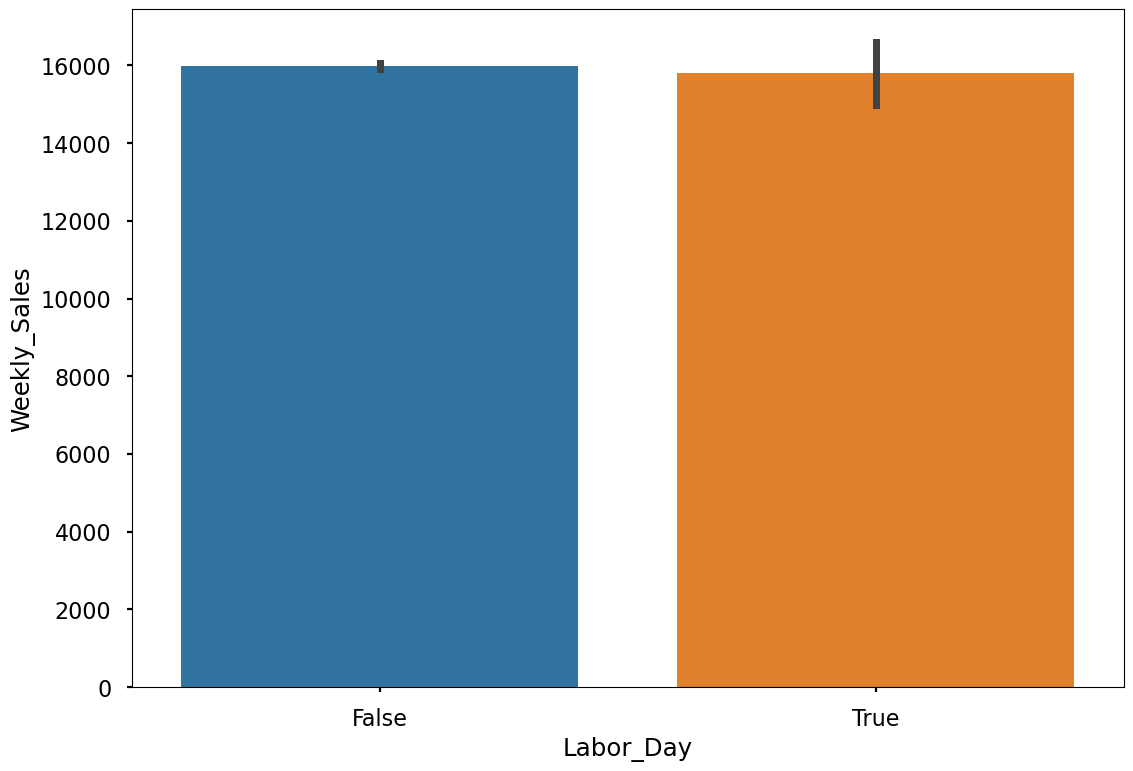

In [189]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

#### Type Effect on Holidays

In [190]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20126.297990
           B       12249.152357
           C        9541.691864
True       A       18231.031306
           B       11394.051524
           C        7963.228980
Name: Weekly_Sales, dtype: float64

In [191]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20101.134269
           B       12238.798217
           C        9519.284506
True       A       19879.540598
           B       11991.583442
           C        9554.978581
Name: Weekly_Sales, dtype: float64

In [192]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       19995.309014
              B       12144.563438
              C        9517.272388
True          A       27370.728296
              B       18661.296519
              C        9679.900152
Name: Weekly_Sales, dtype: float64

In [193]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20099.568043
            B       12237.075977
            C        9519.532538
Name: Weekly_Sales, dtype: float64

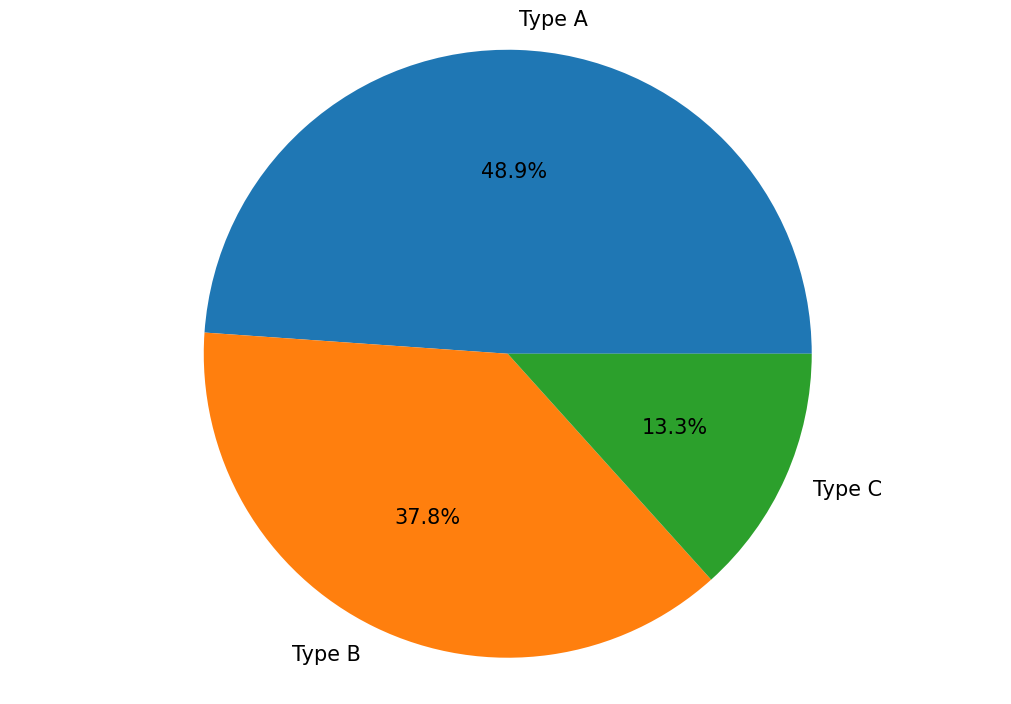

In [194]:
#percentages of store types.
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')

plt.show()

In [195]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15901.445069
True     17035.823187
Name: Weekly_Sales, dtype: float64

Nearly, half of the stores are belongs to Type A.

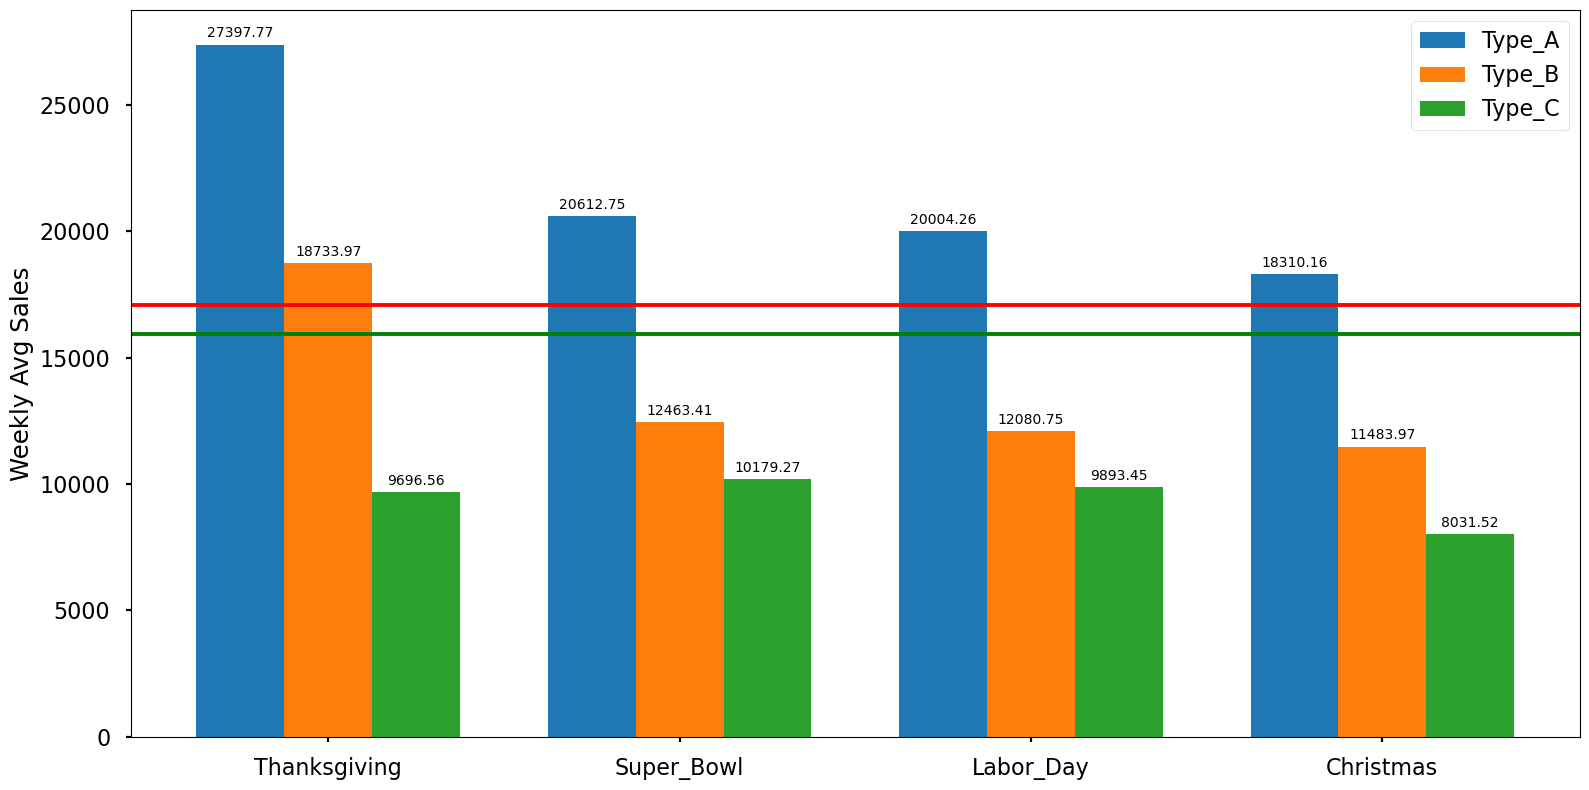

In [196]:
# Plotting avg weekly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()
plt.show()

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales

In [197]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

Store  Dept       Date  Weekly_Sales IsHoliday  Temperature  \
95373      10    72 2010-11-26     693099.36      True    12.961111   
338013     35    72 2011-11-25     649770.18      True     8.822222   
95425      10    72 2011-11-25     630999.19      True    15.933333   
337961     35    72 2010-11-26     627962.93      True     8.150000   
135665     14    72 2010-11-26     474330.10      True     7.861111   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
95373        3.162       0.00        0.0       0.00       0.00       0.00   
338013       3.492    1333.24        0.0   58563.24      20.97    6386.86   
95425        3.760     174.72      329.0  141630.61      79.00    1009.98   
337961       3.039       0.00        0.0       0.00       0.00       0.00   
135665       3.039       0.00        0.0       0.00       0.00       0.00   

               CPI  Unemployment Type    Size Super_Bowl Labor_Day  \
95373   126.669267         9.003    B  126512      False     False   
338013  140.421786         8.745    B  103681      False     False   
95425   129.836400         7.874    B  126512      False     False   
337961  136.689571         8.763    B  103681      False     False   
135665  182.783277         8.724    A  200898      False     False   

       Thanksgiving Christmas  
95373          True     False  
338013         True     False  
95425          True     False  
337961         True     False  
135665         True     False

#### To See the Size - Type Relation

In [198]:
df.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

count       mean       std      min       25%       50%       75%  \
Type                                                                         
A     215478.0  182231.29  41534.53  39690.0  158114.0  202505.0  203819.0   
B     163495.0  101818.74  30921.78  34875.0   93188.0  114533.0  123737.0   
C      42597.0   40535.73   1194.43  39690.0   39690.0   39910.0   41062.0   

           max  
Type            
A     219622.0  
B     140167.0  
C      42988.0

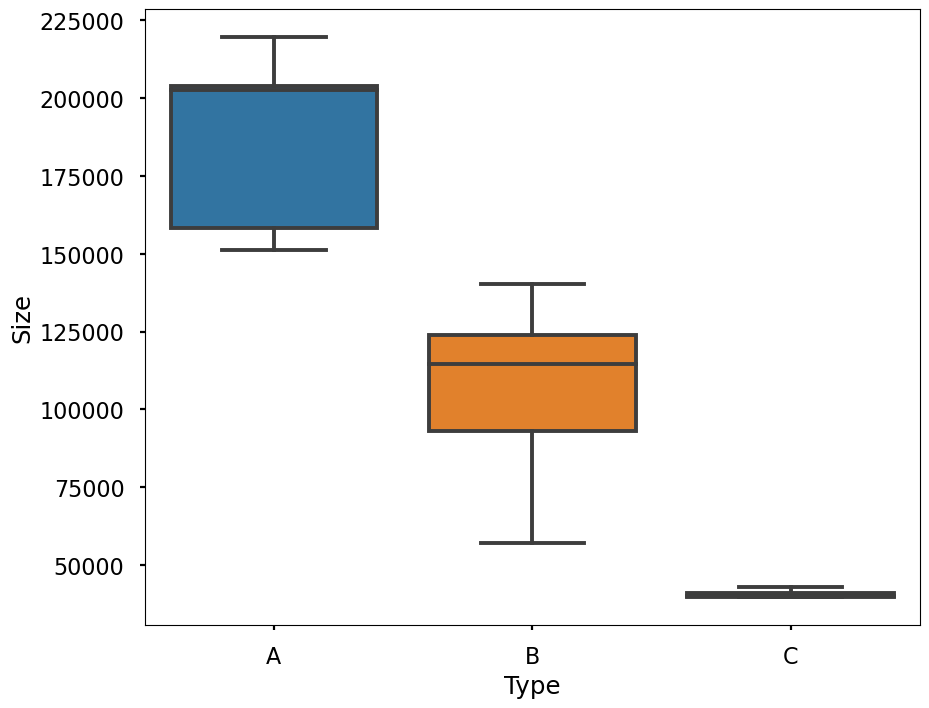

In [199]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

In [200]:
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [201]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14503.308110
2     16026.823127
3     15631.676728
4     15638.149799
5     15850.122787
6     16258.141930
7     15563.149206
8     16012.023938
9     15378.844836
10    15728.044488
11    17271.744814
12    18342.245834
Name: Weekly_Sales, dtype: float64

In [202]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16270.275737
2011    15954.070675
2012    15694.948597
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='month'>

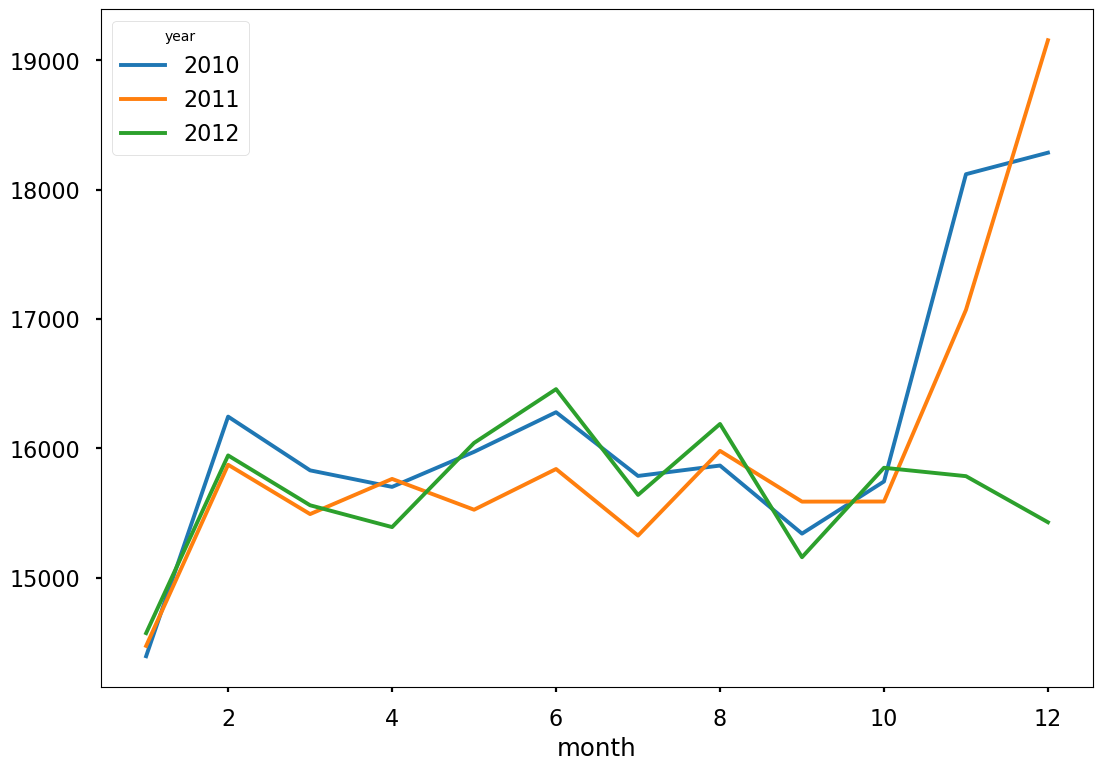

In [203]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values. In 2012  it's mean is near to 2010. Sales in 2011 has suddenly rised for last two months.

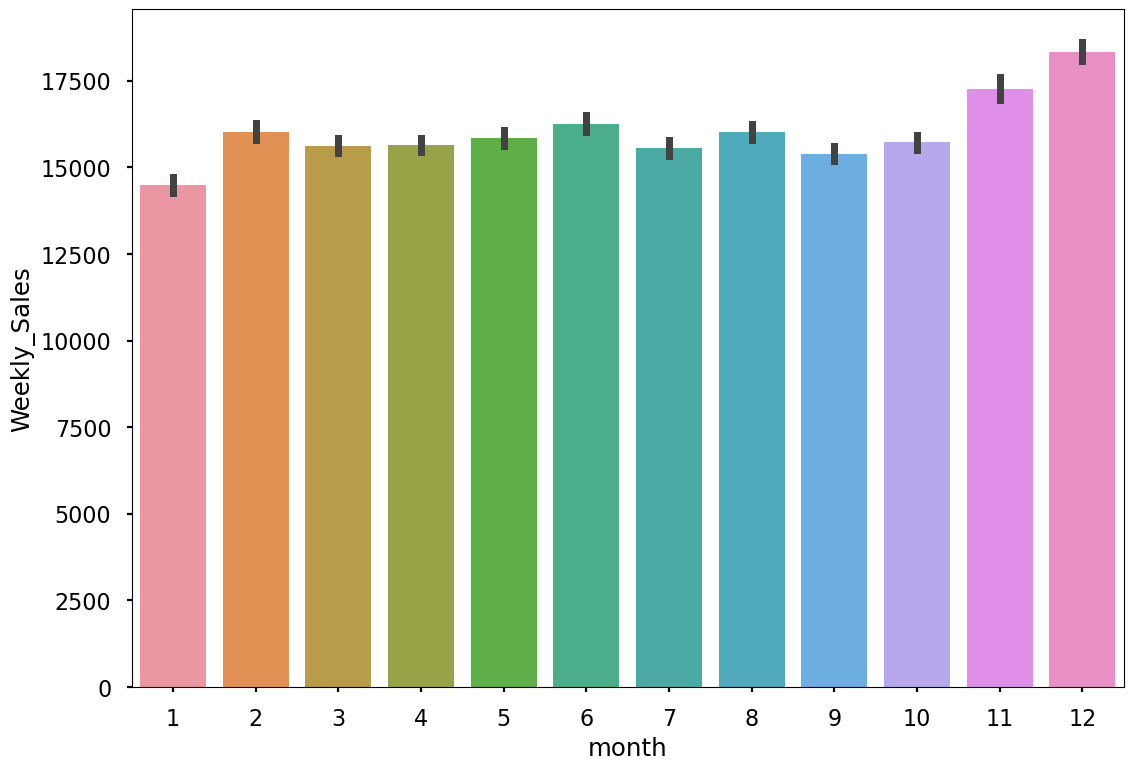

In [204]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [205]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26396.399283
47    22220.944538
50    18749.722165
23    17279.748856
14    16592.112711
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

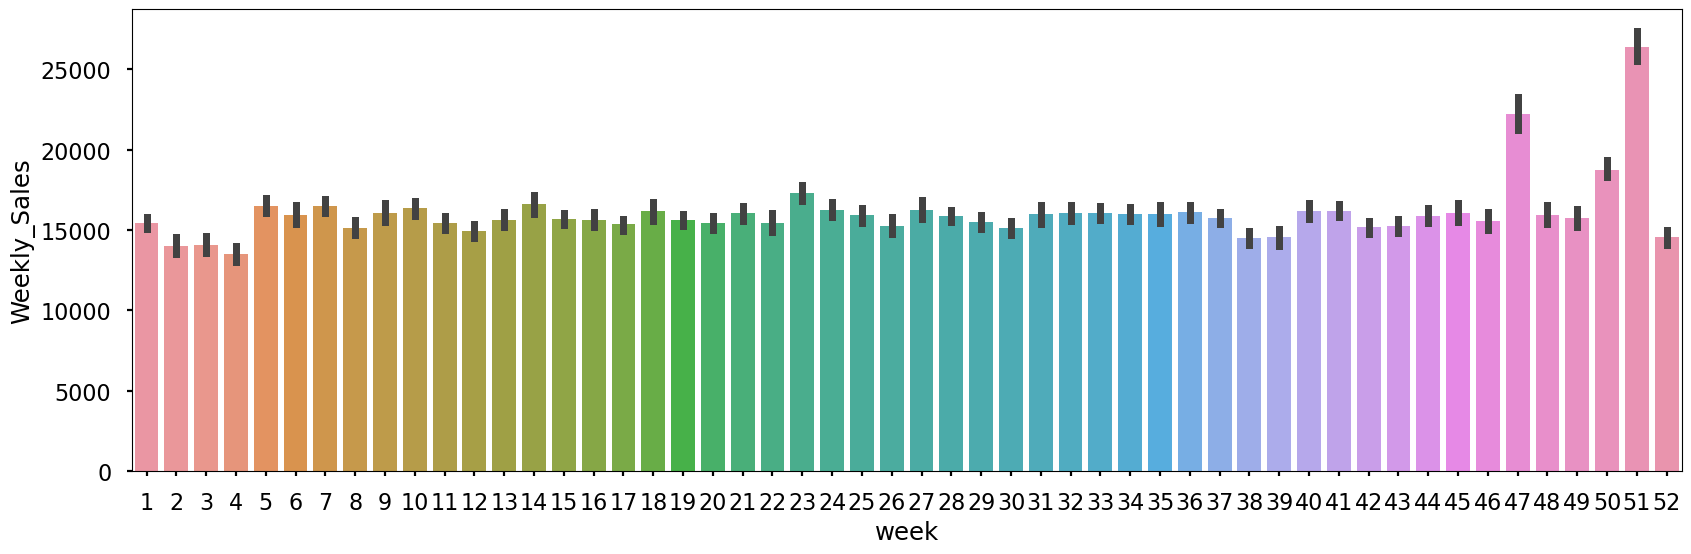

In [206]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

In [207]:
#

<AxesSubplot:xlabel='Fuel_Price'>

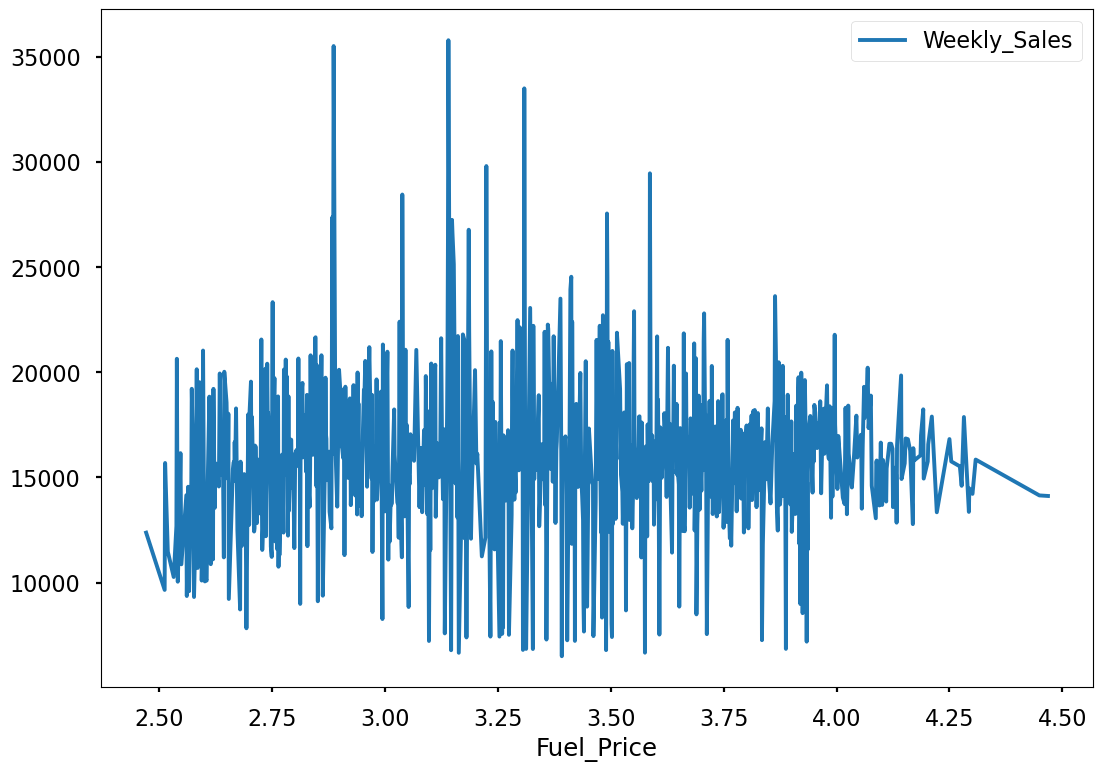

In [208]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<AxesSubplot:xlabel='Temperature'>

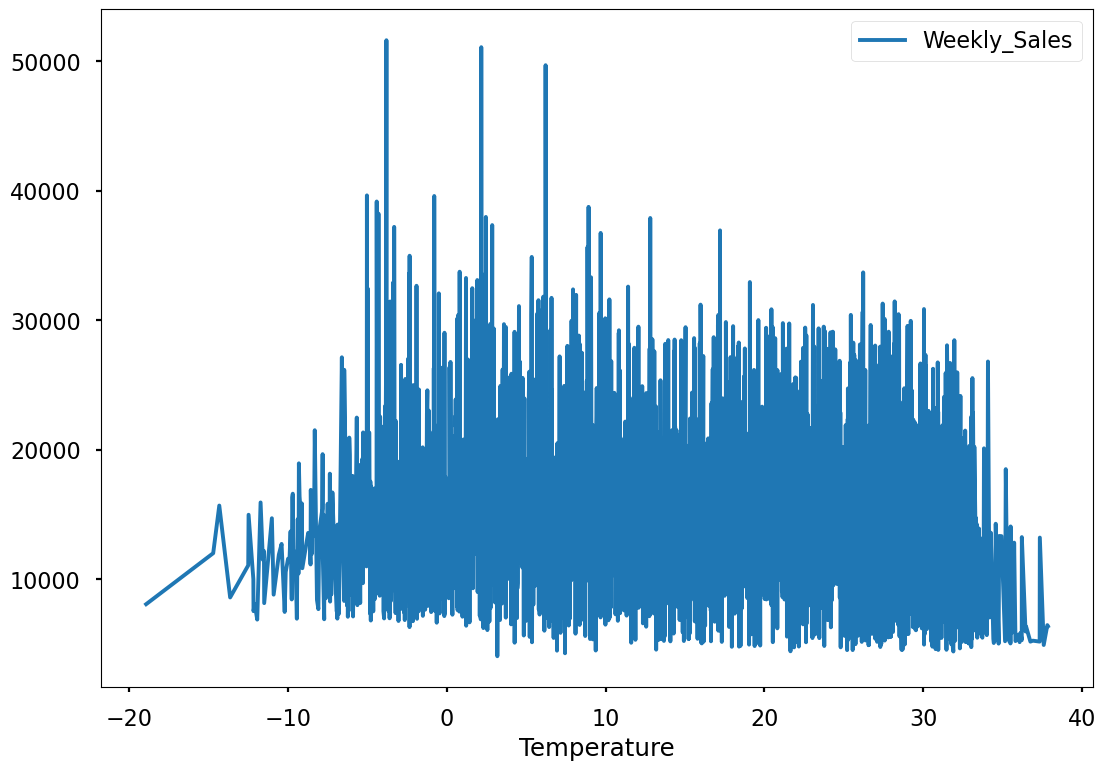

In [209]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<AxesSubplot:xlabel='CPI'>

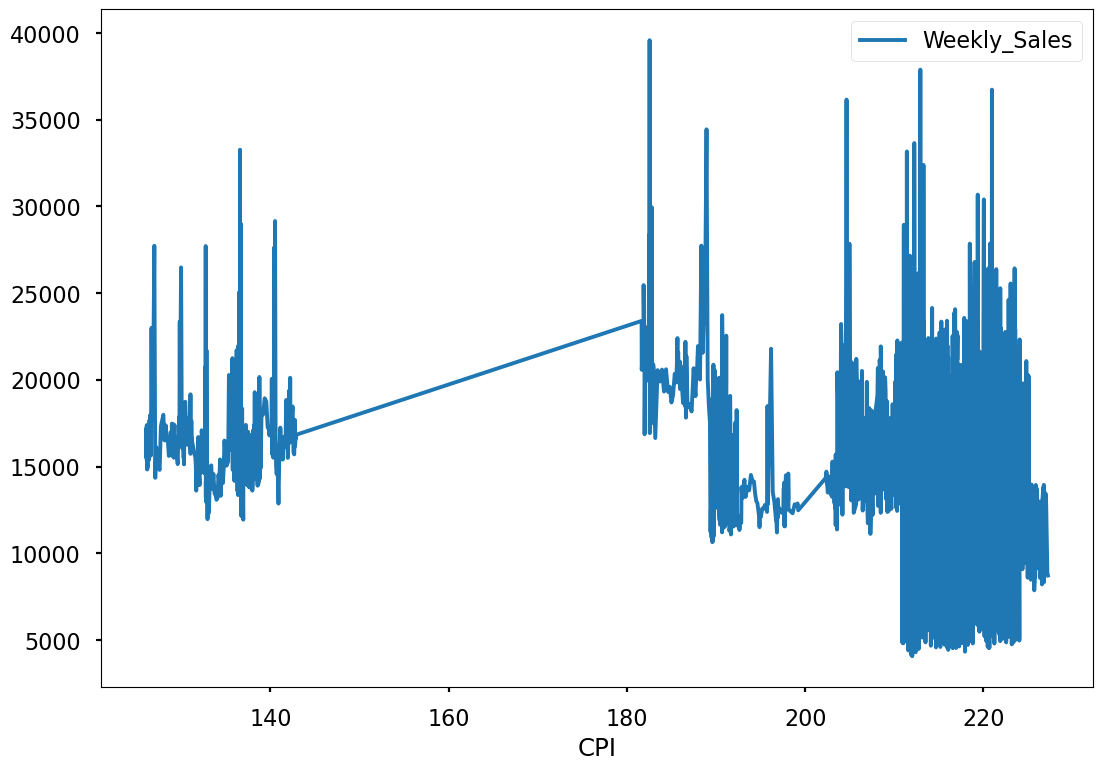

In [210]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<AxesSubplot:xlabel='Unemployment'>

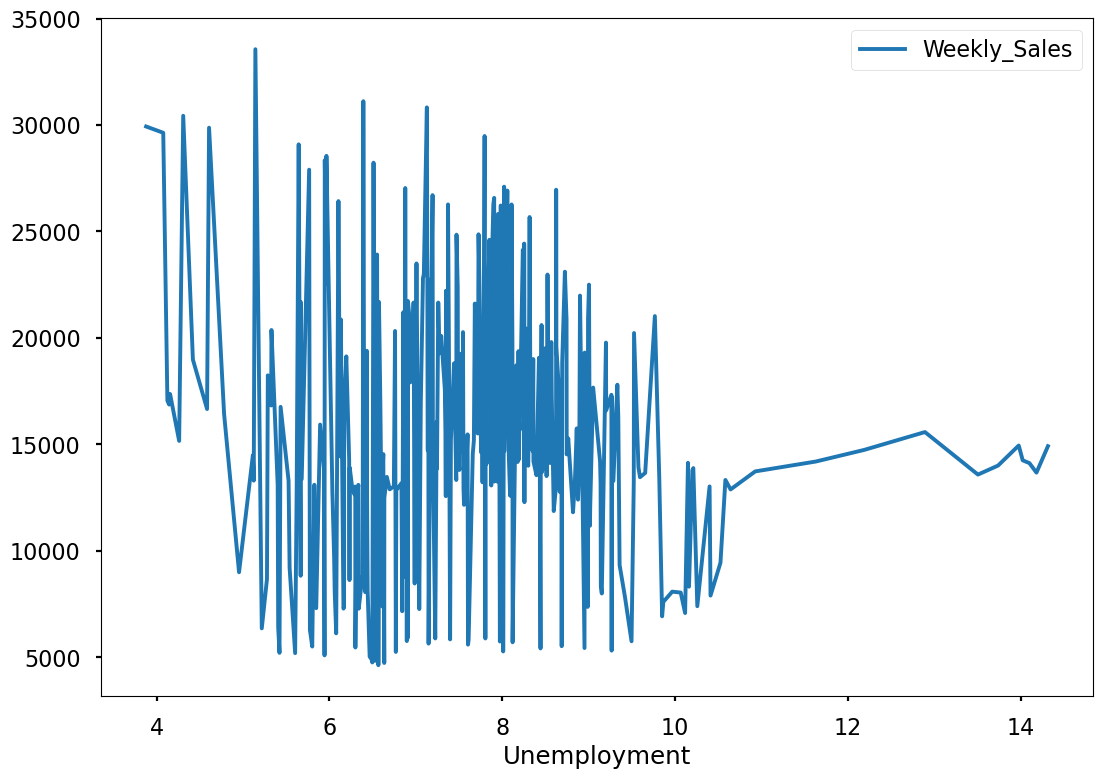

In [211]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

### Tranforming our Data

In [212]:
df_num = df.select_dtypes(np.number)
df_num.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Size', 'week', 'month', 'year'],
      dtype='object')

In [213]:
from sklearn.preprocessing import PowerTransformer

In [214]:
pt=PowerTransformer(method='yeo-johnson')
trans_col=pt.fit_transform(df[['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']])

In [215]:
df_trans=pd.DataFrame(trans_col, columns=['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size'])
df_trans.head()

Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0    -0.975433   -1.685399  -0.740128  -0.210481  -0.317239  -0.679836   
1    -1.178323   -1.734135  -0.740128  -0.210481  -0.317239  -0.679836   
2    -1.102718   -1.802972  -0.740128  -0.210481  -0.317239  -0.679836   
3    -0.742949   -1.707752  -0.740128  -0.210481  -0.317239  -0.679836   
4    -0.749968   -1.577351  -0.740128  -0.210481  -0.317239  -0.679836   

   MarkDown5       CPI  Unemployment     Size  
0   -0.74778  1.020121      0.204134  0.22807  
1   -0.74778  1.022987      0.204134  0.22807  
2   -0.74778  1.023911      0.204134  0.22807  
3   -0.74778  1.024510      0.204134  0.22807  
4   -0.74778  1.025109      0.204134  0.22807

In [216]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Super_Bowl',
       'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year'],
      dtype='object')

In [217]:
df_trans.shape

(421570, 10)

- default settings of yeo-jhonson will apply standard scaler to the data hence we will not scale our data prior to model building. And it will also reduce the impact of outliers in the dataset

In [218]:
# Taking a copy of df
df_encoded=df[['Store', 'Dept', 'Date', 'Weekly_Sales','Type','IsHoliday','Super_Bowl','Thanksgiving','Labor_Day','Christmas','week', 'month', 'year']]

### Label encoding Type and IsHoliday columns

In [219]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [220]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [221]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [222]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [223]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [224]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [225]:
df_encoded.shape

(421570, 13)

In [226]:
df_encoded.head()

Store  Dept       Date  Weekly_Sales  Type  IsHoliday  Super_Bowl  \
0      1     1 2010-05-02      24924.50     1          0           0   
1      1     1 2010-12-02      46039.49     1          1           0   
2      1     1 2010-02-19      41595.55     1          0           0   
3      1     1 2010-02-26      19403.54     1          0           0   
4      1     1 2010-05-03      21827.90     1          0           0   

   Thanksgiving  Labor_Day  Christmas  week  month  year  
0             0          0          0    17      5  2010  
1             0          0          0    48     12  2010  
2             0          0          0     7      2  2010  
3             0          0          0     8      2  2010  
4             0          0          0    18      5  2010

In [227]:
final_data = pd.concat([df_encoded, df_trans], axis=1)
final_data.head()

Store  Dept       Date  Weekly_Sales  Type  IsHoliday  Super_Bowl  \
0      1     1 2010-05-02      24924.50     1          0           0   
1      1     1 2010-12-02      46039.49     1          1           0   
2      1     1 2010-02-19      41595.55     1          0           0   
3      1     1 2010-02-26      19403.54     1          0           0   
4      1     1 2010-05-03      21827.90     1          0           0   

   Thanksgiving  Labor_Day  Christmas  ...  Temperature  Fuel_Price  \
0             0          0          0  ...    -0.975433   -1.685399   
1             0          0          0  ...    -1.178323   -1.734135   
2             0          0          0  ...    -1.102718   -1.802972   
3             0          0          0  ...    -0.742949   -1.707752   
4             0          0          0  ...    -0.749968   -1.577351   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5       CPI  \
0  -0.740128  -0.210481  -0.317239  -0.679836   -0.74778  1.020121   
1  -0.740128  -0.210481  -0.317239  -0.679836   -0.74778  1.022987   
2  -0.740128  -0.210481  -0.317239  -0.679836   -0.74778  1.023911   
3  -0.740128  -0.210481  -0.317239  -0.679836   -0.74778  1.024510   
4  -0.740128  -0.210481  -0.317239  -0.679836   -0.74778  1.025109   

   Unemployment     Size  
0      0.204134  0.22807  
1      0.204134  0.22807  
2      0.204134  0.22807  
3      0.204134  0.22807  
4      0.204134  0.22807  

[5 rows x 23 columns]

In [228]:
# we will drop Date before model as we already have week month and year columns to show that
dft=final_data.drop('Date', axis=1)
dft.head()

Store  Dept  Weekly_Sales  Type  IsHoliday  Super_Bowl  Thanksgiving  \
0      1     1      24924.50     1          0           0             0   
1      1     1      46039.49     1          1           0             0   
2      1     1      41595.55     1          0           0             0   
3      1     1      19403.54     1          0           0             0   
4      1     1      21827.90     1          0           0             0   

   Labor_Day  Christmas  week  ...  Temperature  Fuel_Price  MarkDown1  \
0          0          0    17  ...    -0.975433   -1.685399  -0.740128   
1          0          0    48  ...    -1.178323   -1.734135  -0.740128   
2          0          0     7  ...    -1.102718   -1.802972  -0.740128   
3          0          0     8  ...    -0.742949   -1.707752  -0.740128   
4          0          0    18  ...    -0.749968   -1.577351  -0.740128   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5       CPI  Unemployment     Size  
0  -0.210481  -0.317239  -0.679836   -0.74778  1.020121      0.204134  0.22807  
1  -0.210481  -0.317239  -0.679836   -0.74778  1.022987      0.204134  0.22807  
2  -0.210481  -0.317239  -0.679836   -0.74778  1.023911      0.204134  0.22807  
3  -0.210481  -0.317239  -0.679836   -0.74778  1.024510      0.204134  0.22807  
4  -0.210481  -0.317239  -0.679836   -0.74778  1.025109      0.204134  0.22807  

[5 rows x 22 columns]

<br/>

In [229]:
# OLS MODEL :

In [230]:
y = dft.Weekly_Sales
x = dft.drop('Weekly_Sales',axis=1)

In [231]:
Xc = sm.add_constant(x)
model = sm.OLS(y,Xc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2058.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:30:12   Log-Likelihood:            -4.8071e+06
No. Observations:              421570   AIC:                         9.614e+06
Df Residuals:                  421549   BIC:                         9.615e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.569e+06   2.69e+05     13.282      0.000    3.04e+06     4.1e+06
Store         -101.9961      2.833    -36.002      0.000    -107.549     -96.443
Dept           111.2790      1.095    101.590      0.000     109.132     113.426
Type          1896.5994     87.803     21.601      0.000    1724.508    2068.691
IsHoliday        2.7262    194.404      0.014      0.989    -378.301     383.753
Super_Bowl    -1.15e-05   8.66e-07    -13.282      0.000   -1.32e-05    -9.8e-06
Thanksgiving  4359.8779    358.724     12.154      0.000    3656.789    5062.967
Labor_Day     -320.9529    443.421     -0.724      0.469   -1190.045     548.139
Christmas    -2074.6882    364.741     -5.688      0.000   -2789.569   -1359.807
week          -204.2004     29.721     -6.871      0.000    -262.453    -145.948
month          977.4679    129.516      7.547      0.000     723.620    1231.315
year         -1770.2942    133.617    -13.249      0.000   -2032.179   -1508.410
Temperature    380.6472     36.728     10.364      0.000     308.661     452.634
Fuel_Price     502.2102     68.769      7.303      0.000     367.425     636.996
MarkDown1     -307.0558    336.605     -0.912      0.362    -966.792     352.681
MarkDown2      113.7756     36.886      3.085      0.002      41.480     186.071
MarkDown3      369.6765     39.443      9.372      0.000     292.369     446.984
MarkDown4    -1325.9669    117.432    -11.291      0.000   -1556.130   -1095.804
MarkDown5     2385.8811    283.854      8.405      0.000    1829.536    2942.226
CPI           -675.2339     38.436    -17.568      0.000    -750.568    -599.900
Unemployment  -402.1309     37.353    -10.766      0.000    -475.342    -328.920
Size          6467.2099     58.764    110.053      0.000    6352.034    6582.386
==============================================================================
Omnibus:                   295130.879   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8636185.803
Skew:                           3.007   Prob(JB):                         0.00
Kurtosis:                      24.342   Cond. No.                     1.66e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.2e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### INFERENCE
* Getting r square of 9% aprox
* Now, removing less signicant columns and rebuilding model and checking the summary

In [232]:
cols = list(Xc.columns)
while len(cols)>1:
    Xc = Xc[cols]
    model = sm.OLS(y, Xc).fit()
    p = model.pvalues
    pmax = max(p)
    pid = p.idxmax()
    if pmax>0.05:
        cols.remove(pid)
        print('Var removed:', pid, 'pvalue :', pmax)
    else:
        break

cols

Var removed: IsHoliday pvalue : 0.9888112227344332
Var removed: Labor_Day pvalue : 0.4324921105433247
Var removed: MarkDown1 pvalue : 0.3652301700675279


['const',
 'Store',
 'Dept',
 'Type',
 'Super_Bowl',
 'Thanksgiving',
 'Christmas',
 'week',
 'month',
 'year',
 'Temperature',
 'Fuel_Price',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Size']

In [233]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2421.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:30:16   Log-Likelihood:            -4.8071e+06
No. Observations:              421570   AIC:                         9.614e+06
Df Residuals:                  421552   BIC:                         9.615e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           3.6e+06   2.64e+05     13.641      0.000    3.08e+06    4.12e+06
Store         -101.9351      2.832    -35.992      0.000    -107.486     -96.384
Dept           111.2807      1.095    101.592      0.000     109.134     113.428
Type          1896.7334     87.802     21.602      0.000    1724.644    2068.823
Super_Bowl    1.271e-06   9.32e-08     13.641      0.000    1.09e-06    1.45e-06
Thanksgiving  4379.7043    306.269     14.300      0.000    3779.427    4979.981
Christmas    -2085.9518    314.808     -6.626      0.000   -2702.966   -1468.937
week          -202.4224     29.148     -6.945      0.000    -259.551    -145.293
month          969.3734    126.386      7.670      0.000     721.661    1217.086
year         -1785.5382    131.219    -13.607      0.000   -2042.723   -1528.354
Temperature    378.4238     36.548     10.354      0.000     306.792     450.056
Fuel_Price     503.4904     67.752      7.431      0.000     370.699     636.282
MarkDown2      113.4371     36.882      3.076      0.002      41.150     185.724
MarkDown3      369.4770     39.436      9.369      0.000     292.183     446.771
MarkDown4    -1392.2713     92.177    -15.104      0.000   -1572.935   -1211.608
MarkDown5     2153.0413    111.223     19.358      0.000    1935.047    2371.035
CPI           -674.1029     38.374    -17.567      0.000    -749.314    -598.891
Unemployment  -402.4640     37.297    -10.791      0.000    -475.565    -329.362
Size          6467.3040     58.764    110.056      0.000    6352.129    6582.479
==============================================================================
Omnibus:                   295127.523   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8635495.702
Skew:                           3.007   Prob(JB):                         0.00
Kurtosis:                      24.341   Cond. No.                     4.96e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.92e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### INFERENCE
* Still the r square is aproxx 9%
* We can observe that the OLS model is having very high multicollinearity as its condition number is very high(1.14e+09)
* Since value of Durbin-Watson number is much below 2, it shows our data has positive Autocorrelation
* Low value of F(Statistic) indicates that our linear model does not provide best fit line to our data
* All these leads to the inference that our model is leaning towards Non-linear, non-parametric models

#### Conclusion
* So, we  plan to build Non Linear Machine Learning Models to predict Weekly_Sales

In [234]:
y_predict = model.predict(Xc)

In [235]:
residuals = y - y_predict

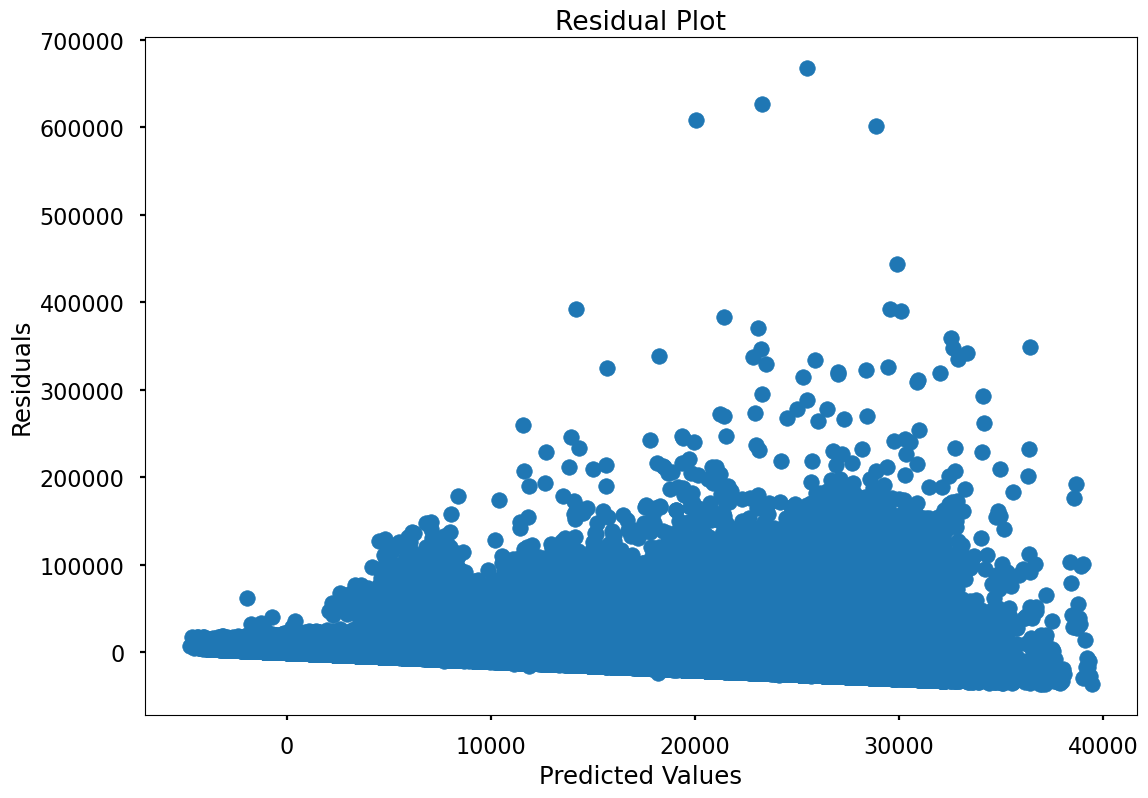

In [236]:
# Create scatter plot of residuals against predicted values
plt.scatter(y_predict, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [237]:
residuals = model.resid
sum(residuals)

-0.6374908866964688

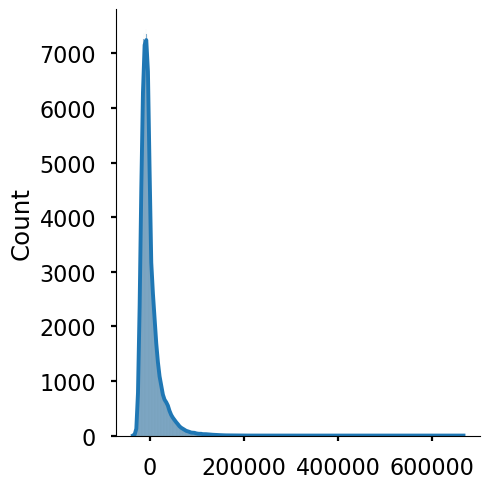

In [238]:
sns.displot(residuals, kde=True)
plt.show()

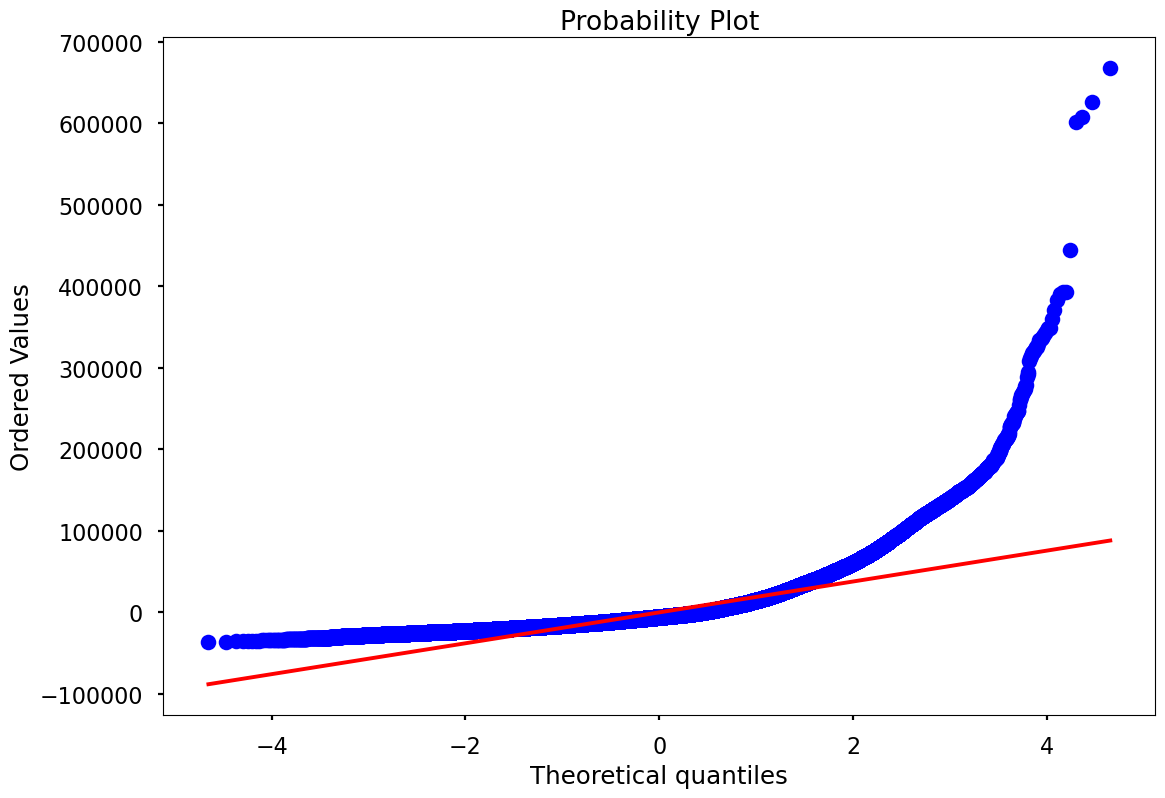

In [239]:
import scipy.stats as stats
stats.probplot(residuals, plot=plt)
plt.show()

- Since the points show a curved pattern, such as a U-shaped pattern, we can conclude that a linear model is not appropriate and that a non-linear model might fit better.

In [240]:
print(stats.jarque_bera(residuals))

Jarque_beraResult(statistic=8635495.701538017, pvalue=0.0)


data_train = data_table[data_table.Weekly_Sales.notnull()]
data_test = data_table[data_table.Weekly_Sales.isnull()]

In [241]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV,LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor

In [242]:
X = dft.drop('Weekly_Sales', axis=1)
y = dft['Weekly_Sales']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [118]:
clfs = {'linreg': LinearRegression(),
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest':RandomForestRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'GradientBoost': GradientBoostingRegressor(),
        'XGBoost': xgb.XGBRegressor(),
        'BaggingRF': BaggingRegressor(base_estimator=RandomForestRegressor()),
        'BaggingAda': BaggingRegressor(base_estimator=AdaBoostRegressor()),
        'BaggingGB': BaggingRegressor(base_estimator=GradientBoostingRegressor()),
        'BaggingXGB': BaggingRegressor(base_estimator=xgb.XGBRegressor())
       }

model_report = pd.DataFrame(columns = ['RMSE', 'MAE','MAPE'])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('Fitting the model .......', clf_name)
    t= pd.Series({
        'Model': clf_name,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    })
    model_report = model_report.append(t,ignore_index=True)
model_report = model_report.sort_values(by='RMSE', ascending=False)
model_report

Fitting the model ....... linreg
Fitting the model ....... DecisionTree
Fitting the model ....... RandomForest
Fitting the model ....... AdaBoost
Fitting the model ....... GradientBoost
Fitting the model ....... XGBoost
Fitting the model ....... BaggingRF
Fitting the model ....... BaggingAda
Fitting the model ....... BaggingGB
Fitting the model ....... BaggingXGB


RMSE           MAE          MAPE          Model
3  25149.505187  20899.200534  2.231152e+16       AdaBoost
7  24019.518984  20337.238983  2.360682e+16     BaggingAda
0  21632.518678  14520.065125  1.527174e+16         linreg
4  11436.858622   6898.035092  7.250579e+15  GradientBoost
8  11379.094906   6870.075744  7.486204e+15      BaggingGB
1   5700.940944   2237.058091  4.547542e+13   DecisionTree
5   5567.051001   3181.882342  2.459306e+15        XGBoost
9   5513.587366   3067.856414  2.538852e+15     BaggingXGB
6   4313.342273   1760.144736  6.027600e+14      BaggingRF
2   4126.491742   1701.296088  4.760115e+14   RandomForest

In [ ]:
# we can note that Random Forest Reressor is giving least Rmse values hence that is the best fit model that is 4126 aprox

To tune the regressor, we can use gridsearch but it takes too much time for this type of data which has many rows and columns. So, we choose regressor parameters manually. We changed the parameters each time and try to find the best result.

In [119]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

### Hyper Parameter Tuning using GridSearchCV finding best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
X = dft.drop('Weekly_Sales', axis=1)
y = dft['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 150, 200 ],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)

# Perform the grid search using GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = grid_search.predict(X_test)

# Calculate the RMSE value
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

<br/>

In [91]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [243]:
# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print('Root Mean squared error:', np.sqrt(mse))
print('R-squared:', r2)

Mean squared error: 17891427.989189506
R-squared: 0.965094194019948


In [244]:
train_score = rf_regressor.score(X_train, y_train)
print('Training_Score', train_score)

Training_Score 0.9953228632739162


In [245]:
test_score = rf_regressor.score(X_test, y_test)
print('Training_Score', test_score)

Training_Score 0.965094194019948


##### As per Random Forest Regressor our Model is predicting Weekly Sales with 96.5% accuracy

<br/>

Observation of Interactions between Features

In [247]:
df_new=final_data.head()

Firstly, i will drop divided holiday columns from my data and try without them. To keep my encoded data safe, I assigned my dataframe to new one and I will use for this.

In [248]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

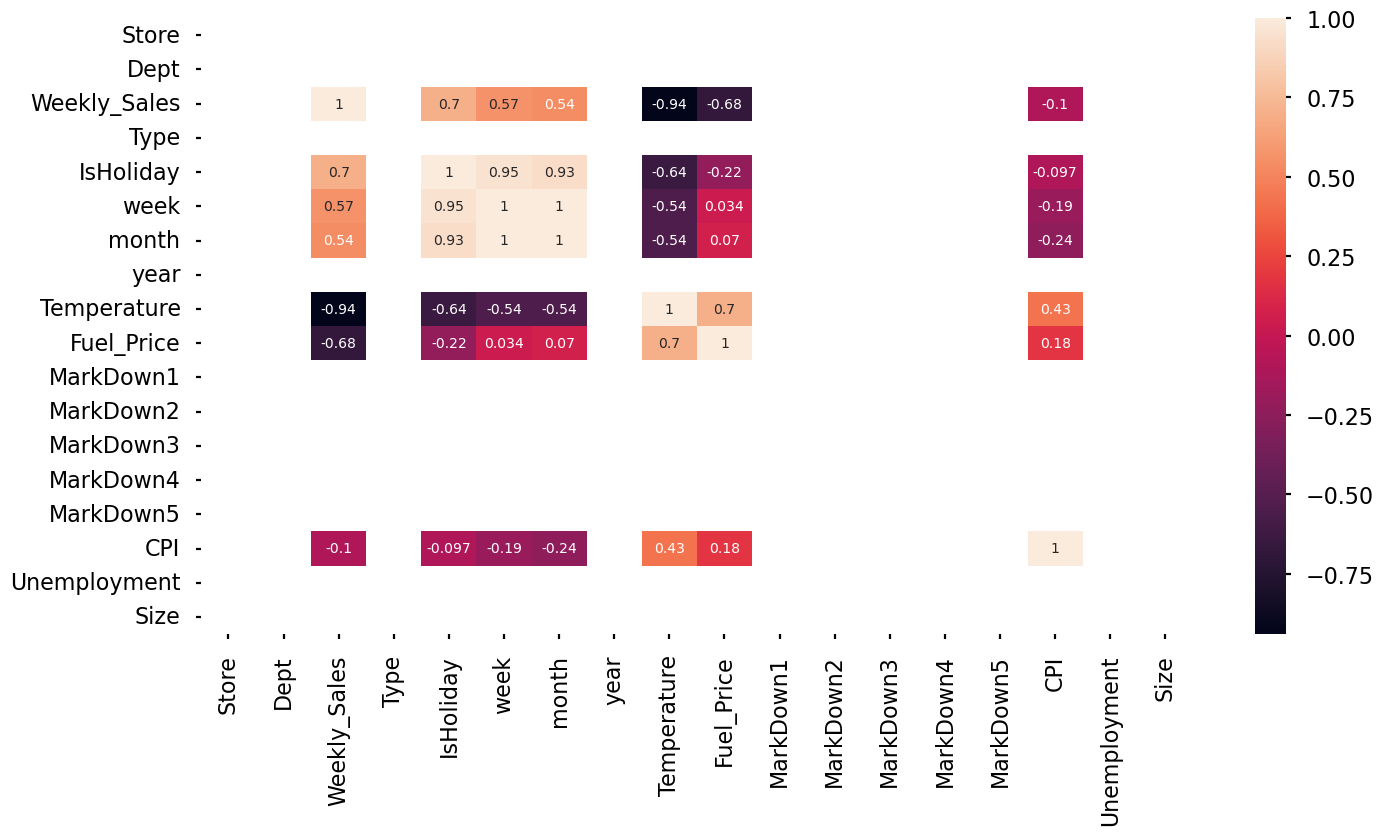

In [249]:
plt.figure(figsize = (16,8))
sns.heatmap(df_new.corr(),annot=True)    # To see the correlations
plt.show()

In [250]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

In [257]:
# dropping columns will very less correlation to weekly sales to improvethe model
df_new.drop(['Store','Dept','Type','year',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Unemployment','Size'], axis=1, inplace=True)

### Creating Train-Test Splits
- Our date column has continuos values, to keep the date features continue, I will not take random splitting. so, I split data manually according to 70%.

In [258]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [259]:
X = df_new[used_cols] # to keep train and test X values together

We have enough information in our date such as week of the year. So, we drop date columns.

In [260]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

In [261]:
# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print('Root Mean squared error:', np.sqrt(mse))
print('R-squared:', r2)

Root Mean squared error: 11872.729260813316
R-squared: 0.03813416640575884


 we can note that even after dropping less correlated attributes there is no improvement in RMSE hence we will chose our first random forest model as best fit model with 4126 RMSE value, it means our model can learn from columns which I dropped before.

### Finding Important Features

In [255]:
# create a Random Forest Regressor
rf = RandomForestRegressor()

# fit the model on the training data
rf.fit(X_train, y_train)
# extract feature importances
importances = rf.feature_importances_

# create a DataFrame to store feature importances
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# sort the DataFrame by feature importance
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

# print the top 10 features by importance
print(feature_importances.head(10))


        feature  importance
0          week    0.301181
1   Temperature    0.245044
2    Fuel_Price    0.213108
3           CPI    0.132770
4         month    0.107897
5     MarkDown2    0.000000
6  Unemployment    0.000000
7     MarkDown5    0.000000
8     MarkDown4    0.000000
9     MarkDown3    0.000000


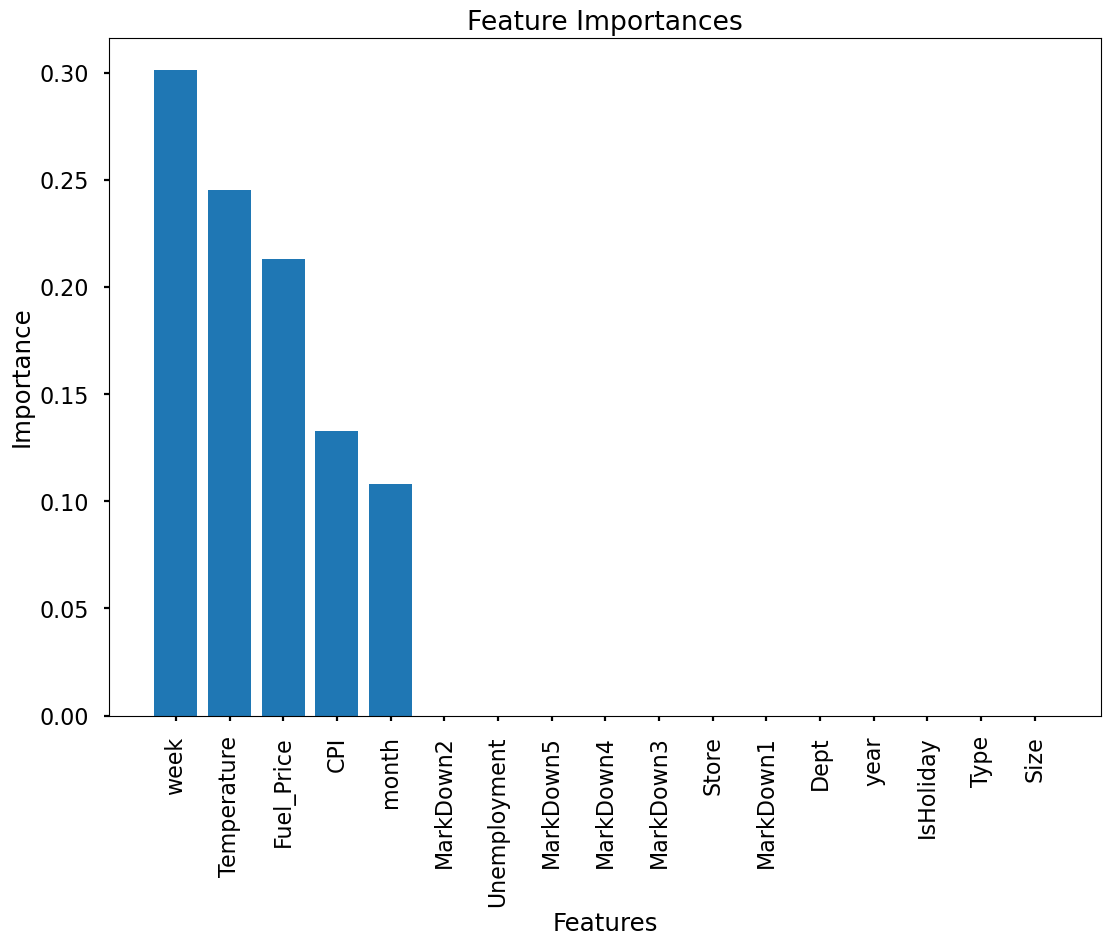

In [256]:
plt.bar(feature_importances['feature'], feature_importances['importance'])

# add labels and title to the chart
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# display the chart
plt.show()

We can clearly see that week, month, Temperature, Fuel Price  the only Important Features to Predict Weekly using Random Forest Regressor

### Time Series Analysis

In [126]:
df.head()

Store  Dept       Date  Weekly_Sales IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-05-02      24924.50     False     5.727778       2.572   
1      1     1 2010-12-02      46039.49      True     3.616667       2.548   
2      1     1 2010-02-19      41595.55     False     4.405556       2.514   
3      1     1 2010-02-26      19403.54     False     8.127778       2.561   
4      1     1 2010-05-03      21827.90     False     8.055556       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  Unemployment  Type    Size  \
0        0.0        0.0        0.0  ...         8.106     A  151315   
1        0.0        0.0        0.0  ...         8.106     A  151315   
2        0.0        0.0        0.0  ...         8.106     A  151315   
3        0.0        0.0        0.0  ...         8.106     A  151315   
4        0.0        0.0        0.0  ...         8.106     A  151315   

   Super_Bowl Labor_Day  Thanksgiving Christmas week month  year  
0       False     False         False     False   17     5  2010  
1       False     False         False     False   48    12  2010  
2       False     False         False     False    7     2  2010  
3       False     False         False     False    8     2  2010  
4       False     False         False     False   18     5  2010  

[5 rows x 23 columns]

In [127]:
df.set_index('Date', inplace=True) #seting date as index

### Plotting Sales

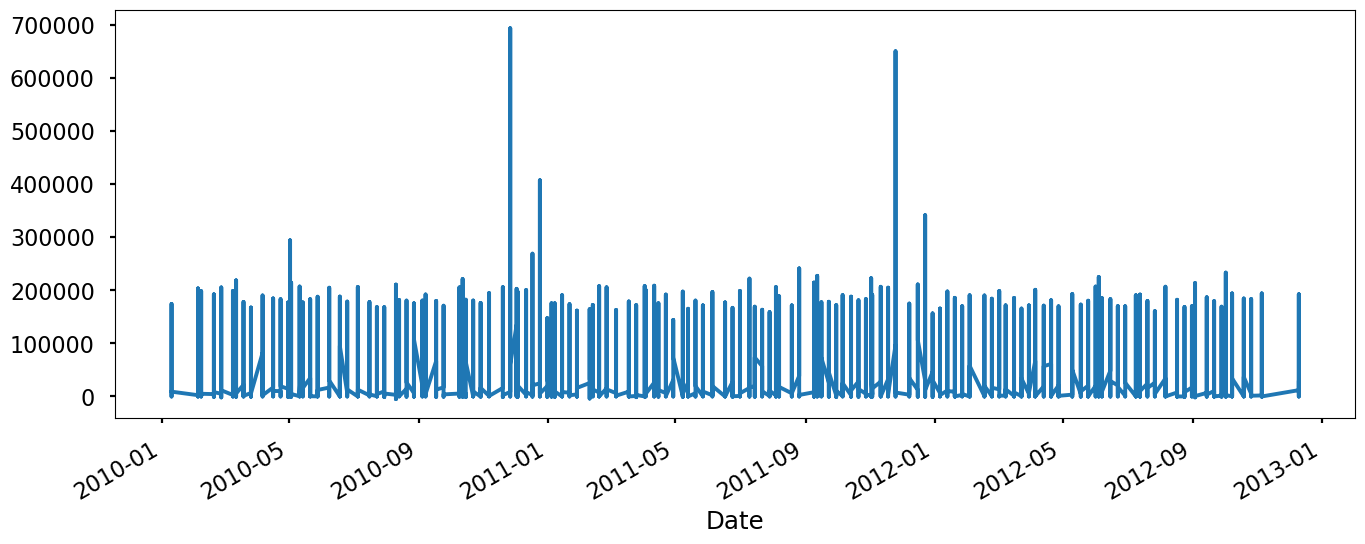

In [128]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, we will collect them together as weekly.

In [129]:
df.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
week            0
month           0
year            0
dtype: int64

In [159]:
df_week = df.resample('W').mean() #resample data as weekly

In [163]:
df_week=df_week.dropna(axis=0)

In [165]:
df_week[df_week.isnull()].sum()

Store           0.0
Dept            0.0
Weekly_Sales    0.0
Temperature     0.0
Fuel_Price      0.0
MarkDown1       0.0
MarkDown2       0.0
MarkDown3       0.0
MarkDown4       0.0
MarkDown5       0.0
CPI             0.0
Unemployment    0.0
Size            0.0
week            0.0
month           0.0
year            0.0
dtype: float64

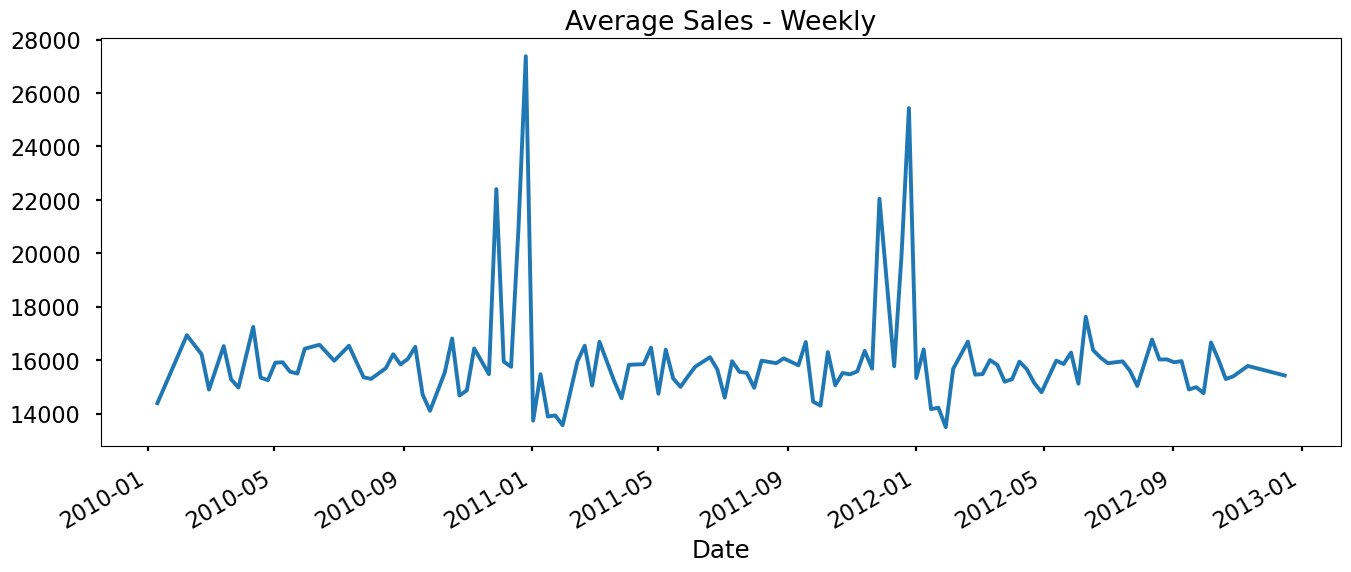

In [166]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

With the collecting data as weekly, we can see average sales clearly. To see monthly pattern , we resampled our data to monthly also.

In [167]:
df_month = df.resample('MS').mean() # resampling as monthly

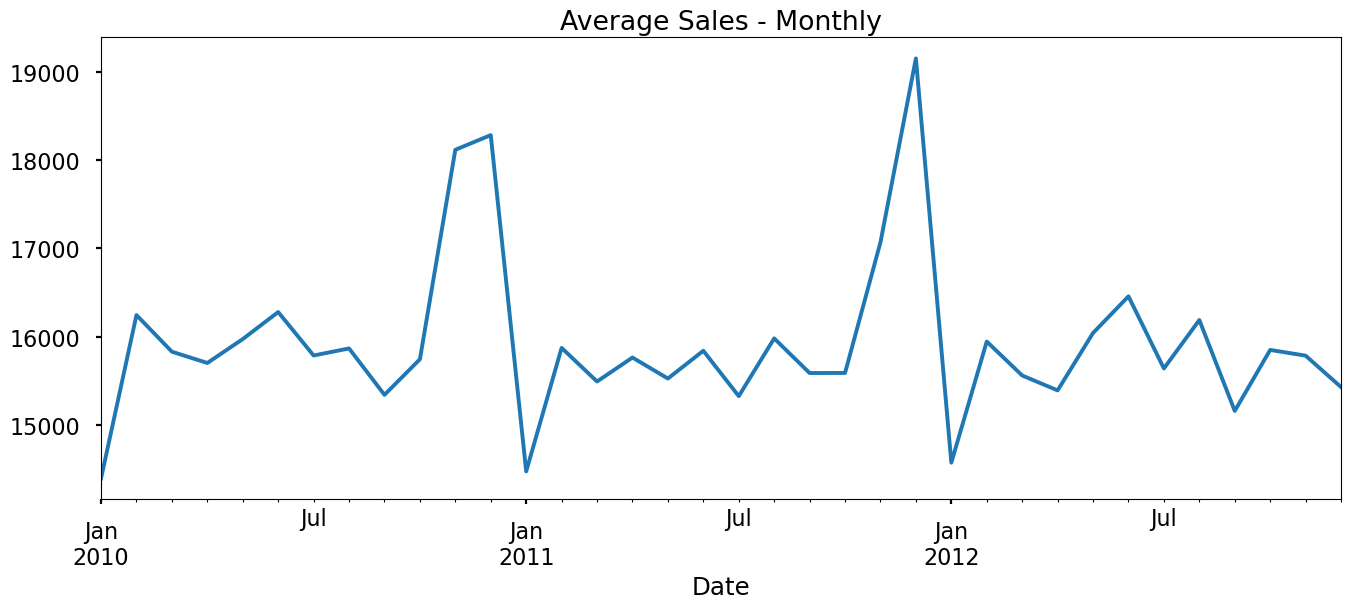

In [168]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When we turned data to monthly, realized that we lost some patterns in weekly data. So, we will continue with weekly resampled data.

### To Observe 2-weeks Rolling Mean and Std

Our data is non-stationary. So, we will try to find more stationary version on it.

In [169]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

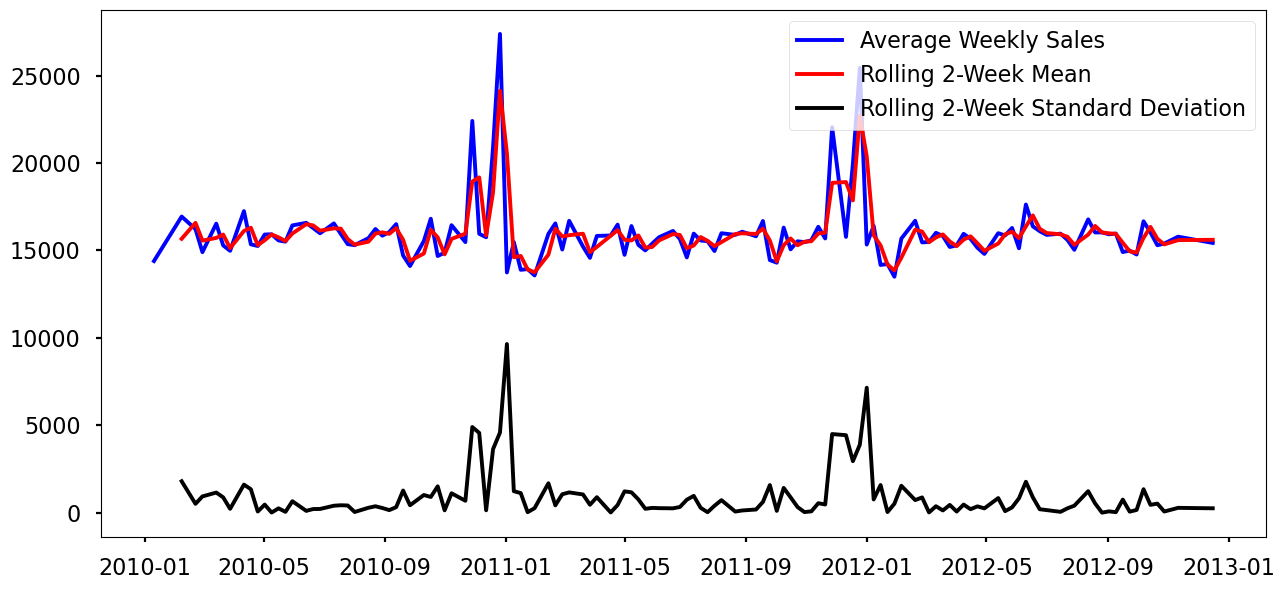

In [170]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

### Adfuller Test to Make Sure

In [171]:
adfuller(df_week['Weekly_Sales'])

(-9.33036800879878,
 9.364103857376136e-16,
 0,
 126,
 {'1%': -3.4833462346078936,
  '5%': -2.8847655969877666,
  '10%': -2.5791564575459813},
 2028.9397895101497)

From test and our observations, the data is not stationary. So, we will try to find more stationary version of it.

### Train - Test Split of Weekly Data

To take train-test splits continuosly, we split them manually, not random.

In [172]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (88, 16)
Test: (39, 16)


In [173]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

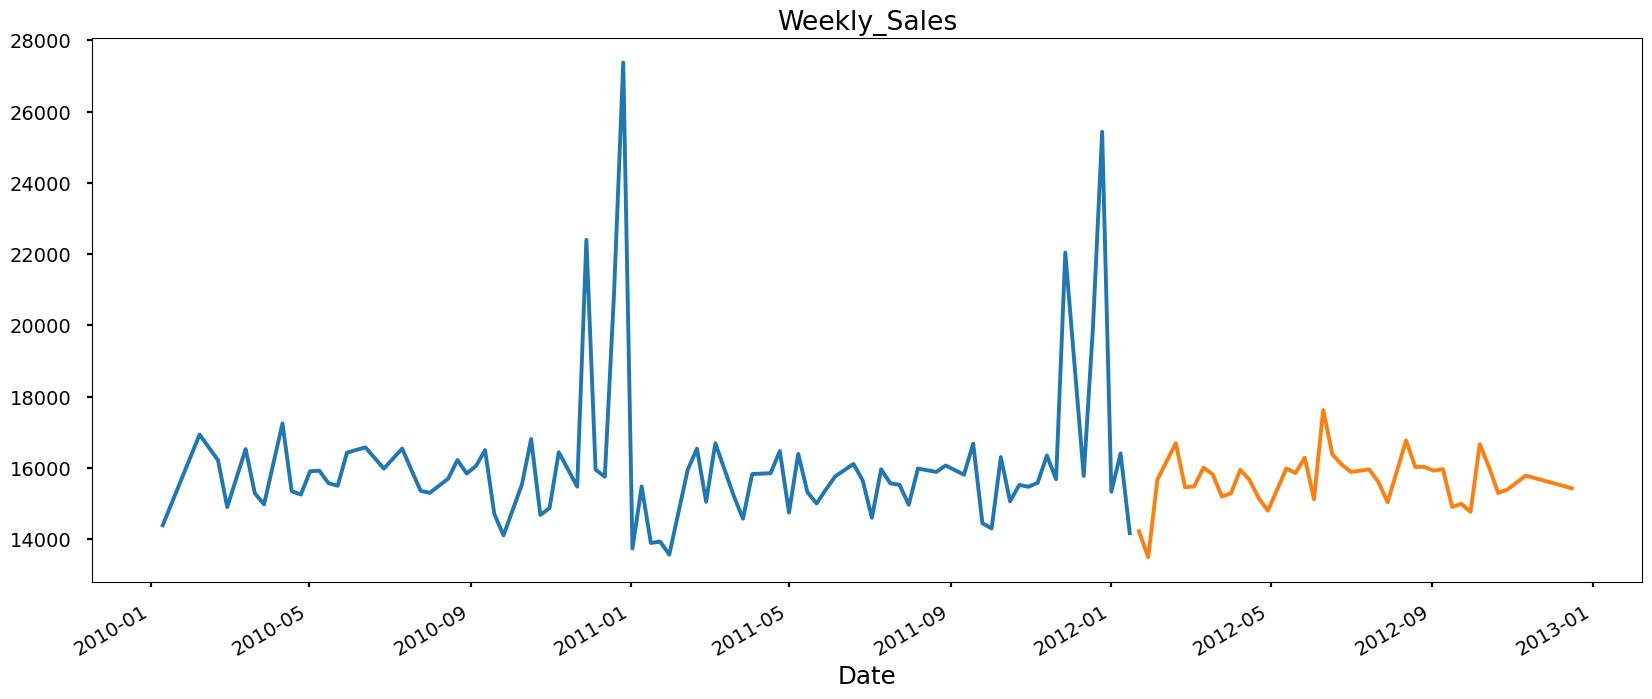

In [174]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data

### Decomposing Weekly Data to Observe Seasonality

In [175]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

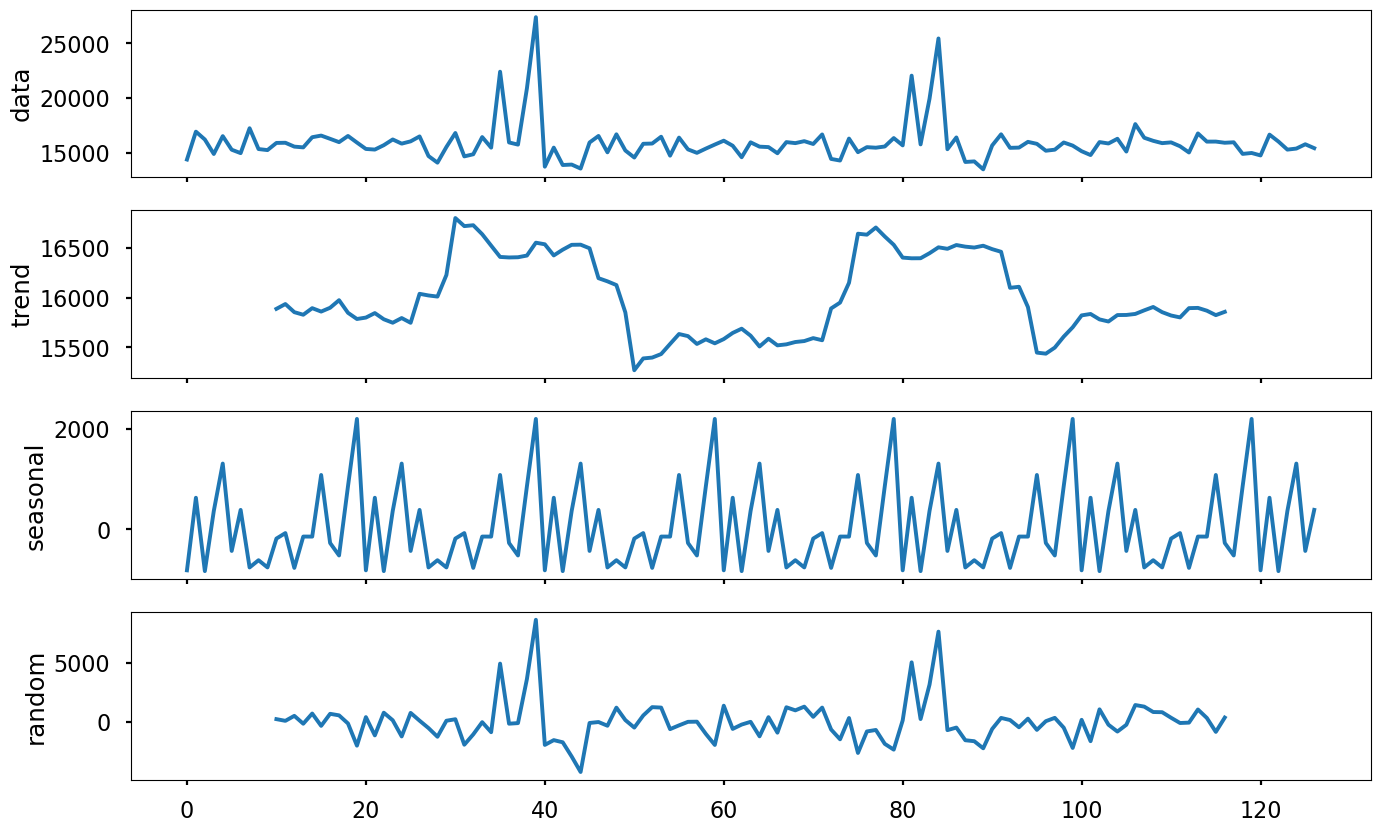

In [176]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps us to tune my model.

### Trying To Make Data More Stationary

Now, we will try to make my data more stationary. To do this, we will try model with differenced, logged and shifted data.

#### 1. Difference

In [207]:
df_week_diff = pd.DataFrame(df_week['Weekly_Sales'].diff().dropna()) #creating difference values

In [208]:
df_week_diff.columns

Index(['Weekly_Sales'], dtype='object')

In [178]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

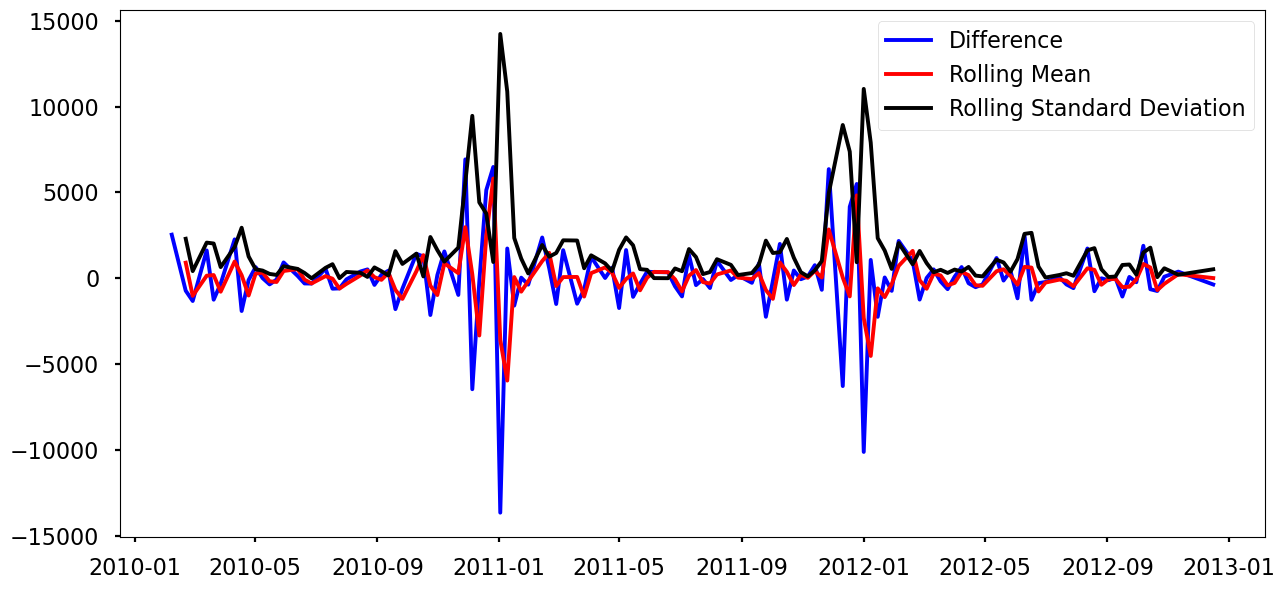

In [179]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

#### 2. Shift

In [180]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data 

In [181]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

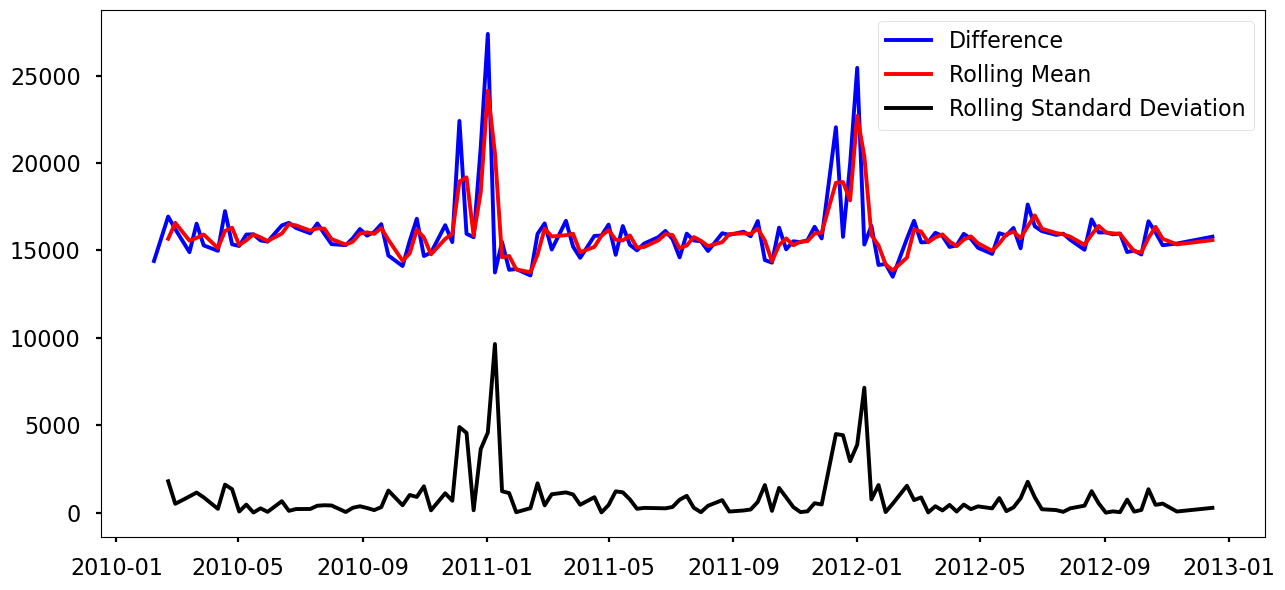

In [182]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

#### 3.Log

In [183]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [184]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

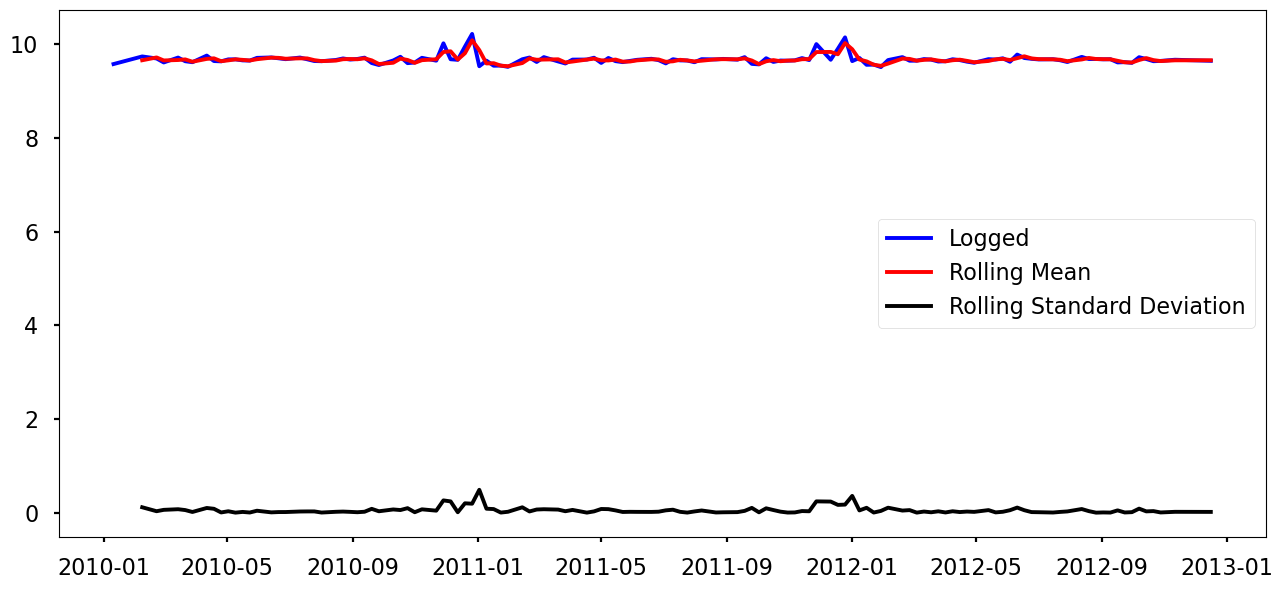

In [185]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

### Auto-ARIMA MODEL

Tried our data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, we decided to take difference and use this data.

In [198]:
train_data_diff = pd.DataFrame(df_week_diff[:int(0.7*(len(df_week_diff )))])
test_data_diff = pd.DataFrame(df_week_diff[int(0.7*(len(df_week_diff ))):])

In [209]:
df_week_diff.head()

Weekly_Sales
Date                    
2010-02-07   2543.322731
2010-02-21   -718.444287
2010-02-28  -1317.109291
2010-03-14   1628.669119
2010-03-21  -1241.445229

In [229]:
train_data = train_data_diff['Weekly_Sales']
test_data = test_data_diff['Weekly_Sales']
model = pm.auto_arima(train_data, seasonal=False, suppress_warnings=True)

# Make predictions on a test set of data
train_data = train_data[:-38] # use all but the last 30% data points for training
test_data = test_data[-38:] # use the last 30% data points for testing
y_pred1 = model.predict(n_periods=len(test_data))

# Calculate the RMSE value
mse = mean_squared_error(test_data, y_pred1)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


RMSE: 963.3702668718358


### Exponential Smoothing Model

Our difference data has some minus and zero values, so we used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, we changed and tried model for different parameters and found the best parameters and fit them to model.

In [233]:
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.

# Make predictions on the test set
y_pred = model_holt_winters.forecast(len(test_data))# Predict the test data

# Calculate the RMSE value
mse = mean_squared_error(test_data, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 1759.180094518985


At the end, we found best results for our data with Auto Arima Model.

The best result for this project is 963 RMSE value. According to sales amounts, this value is roughly around 4-5% error. If we can take our average sales and take percentage of 963 errors, it gives 4-5% roughly.